# Imports and Data Munging

In [1]:
from __future__ import print_function

import sys
import pyodbc
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import math

from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
from sklearn.metrics import mean_squared_error

#make the layout full width
from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#prefer locally cached copy of SQL Server data
runSql = True

connectionString = ''

Import the raw data and convert to TAB track name

In [2]:
def ChangetoTabTrackName(df):
    df = df.replace('MORPHETTVILLE PARKS', 'MORPHETTVILLE')
    df = df.replace('ROYAL RANDWICK', 'RANDWICK')
    df = df.replace('DEVONPORT TAPETA SYNTHETIC', 'DEVONPORT')
    df = df.replace('KENSINGTON', 'RANDWICK')
    df = df.replace('GEELONG SYNTHETIC', 'GEELONG')
    df = df.replace('ROSEHILL GARDENS', 'ROSEHILL')
    df = df.replace('CANTERBURY PARK', 'CANTERBURY')
    df = df.replace('PAKENHAM SYNTHETIC', 'PAKENHAM')
    df = df.replace('ESPERANCE BAY', 'ESPERANCE')
    df = df.replace('SANDOWN PARK HILLSIDE', 'SANDOWN')
    df = df.replace('SANDOWN PARK LAKESIDE', 'SANDOWN')
    df = df.replace('PINJARRA PARK', 'PINJARRA')
    df = df.replace('BALLARAT SYNTHETIC', 'BALLARAT')
    df = df.replace('GLOUCESTER PARK', 'GLOUCESTER PK')  
    df = df.replace('NEWCASTLE (AUS)', 'NEWCASTLE') 
    df = df.replace('ASCOT (AUS)', 'ASCOT')
    df = df.replace('KANGAROO ISLAND', 'KANGAROO ISL')
    df = df.replace('MOUNT ISA', 'MT ISA')
    
    return df

## Load the tip data

In [3]:
tipsSql = "select * from GtoTip"

if runSql:
    cnxn = pyodbc.connect(connectionString)
    tips = pd.read_sql(tipsSql,cnxn)
    tips['Venue'] = tips['Venue'].apply(lambda x: ChangetoTabTrackName(x))
    tips.to_csv('tipsGto.csv', index=False, date_format='%Y%m%d')

#read cached copy for speed and to avoid SQL ODBC pains 
tips= pd.read_csv('tipsGto.csv')
tips['TipDate'] = pd.to_datetime(tips['TipDate'], format="%Y-%m-%d")
tips.head()

GtoTipId    TipDate    Venue  RaceNo           Runner  IsBestBet  \
0         1 2019-10-09  WODONGA       6   Richwaite Lady      False   
1         2 2019-10-19  WODONGA       5        Carwelkin      False   
2         3 2019-10-19  WODONGA       4       Grey Honor      False   
3         4 2019-10-19  WODONGA       3  Atunnah Courage      False   
4         5 2019-10-19  WODONGA       2         Annabeth      False   

          Tipster Type  
0  Adam Olszanski    R  
1  Adam Olszanski    R  
2  Adam Olszanski    R  
3  Adam Olszanski    R  
4  Adam Olszanski    R

## Load Betfair and State data

Supplement the original data with finish position data and BSP Place Data.  Data downloaded from APIs used to populate https://www.betfair.com.au/hub/racing-results/ 

In [4]:
venuesSql = "select s.StateName, v.VenueName from Venue v inner join State s on s.StateId = v.StateId"

if runSql:
    cnxn = pyodbc.connect(connectionString)
    venues = pd.read_sql(venuesSql,cnxn)
    venues.to_csv('venues.csv', index=False, date_format='%Y%m%d')

#read cached copy for speed and to avoid SQL ODBC pains 
venues= pd.read_csv('venues.csv')

In [5]:
#add a Betfair Market Base Rate column
def GetMBR(state):
    if state == "NSW":
        return .1
    elif state == "WA":
        return 0.08
    elif state == "ACT":
        return 0.07
    else:
        return 0.06

In [6]:
runnersWithFinishPositionSql = \
'''
select m.MeetingName, m.MeetingDate, m.RaceType, r.RaceNumber, rnr.RunnerNumber, rnr.RunnerName, rnr.FinishPosition,
rnr.BspWin, rnr.BspPlace, rnr.BestTote
from [dbo].[BfMeeting] m  
inner join [dbo].[BfRace] r on m.BfMeetingId = r.BfMeetingId
inner join [dbo].[BfRunner] rnr on rnr.BfRaceId = r.BfRaceId
where m.[MeetingDate] >= '1 Oct 2018' and json_value(m.[RawData], '$.country') = 'AUS'
'''

if runSql:
    cnxn = pyodbc.connect(connectionString)
    runnersWithFinishPosition = pd.read_sql(runnersWithFinishPositionSql,cnxn)
    runnersWithFinishPosition.to_csv('BetfairData.csv', index=False, date_format='%Y%m%d')

#read cached copy for speed and to avoid SQL ODBC pains 
runnersWithFinishPosition= pd.read_csv('BetfairData.csv')
runnersWithFinishPosition['MeetingDate'] = pd.to_datetime(runnersWithFinishPosition['MeetingDate'], format="%Y-%m-%d")

#add columns for state and MBR
runnersWithFinishPosition['MeetingNameUpper'] = runnersWithFinishPosition['MeetingName'].apply(lambda x: x.upper())
runnersWithFinishPosition['MeetingNameUpper'] = runnersWithFinishPosition['MeetingNameUpper'].apply(lambda x: ChangetoTabTrackName(x))
runnersWithFinishPosition = pd.merge(runnersWithFinishPosition, venues,  how='left', left_on=['MeetingNameUpper'],  right_on = ['VenueName'])
runnersWithFinishPosition['MBR'] = runnersWithFinishPosition['StateName'].apply(lambda x: GetMBR(x))

#remove scratched
runnersWithFinishPosition = runnersWithFinishPosition[runnersWithFinishPosition['BspWin'] != 0].copy()

## Join tips and Betfair

In [7]:
import re
def RunnerNameClean(name):
    name = name.lower()
    return re.sub(r'\W+', '', name)

runnersWithFinishPosition['RunnerNameClean'] = runnersWithFinishPosition['RunnerName'].apply(lambda x: RunnerNameClean(x))
tips['RunnerClean'] = tips['Runner'].apply(lambda x: RunnerNameClean(x))

In [8]:
tipsWithBetfair = pd.merge(runnersWithFinishPosition, tips,  how='inner', left_on=['VenueName','MeetingDate', 'RaceType', 'RaceNumber', 'RunnerNameClean'], 
                           right_on = ['Venue', 'TipDate', 'Type', 'RaceNo', 'RunnerClean'])
tipsWithBetfair["WON"] = tipsWithBetfair["FinishPosition"] == 1
tipsWithBetfair.head()

MeetingName MeetingDate RaceType  RaceNumber  RunnerNumber       RunnerName  \
0     Geelong  2018-10-01        R           1             8   No Drama Darci   
1     Geelong  2018-10-01        R           2             2  Its La Premiere   
2     Geelong  2018-10-01        R           3             8          Hasabro   
3     Geelong  2018-10-01        R           4             9      Collectable   
4     Geelong  2018-10-01        R           5             1      Beau Soleil   

   FinishPosition  BspWin  BspPlace  BestTote  ... GtoTipId    TipDate  \
0               2    3.05      1.39       2.9  ...     6422 2018-10-01   
1               7    4.10      1.67       3.8  ...     6421 2018-10-01   
2               2    2.30      1.32       2.1  ...     6420 2018-10-01   
3               2    7.40      2.26       7.4  ...     6419 2018-10-01   
4               8   29.00      5.60      17.8  ...     6418 2018-10-01   

     Venue  RaceNo            Runner  IsBestBet          Tipster Type  \
0  GEELONG       1    No Drama Darci      False  Adam Crettenden    R   
1  GEELONG       2  It's La Premiere      False  Adam Crettenden    R   
2  GEELONG       3           Hasabro      False  Adam Crettenden    R   
3  GEELONG       4       Collectable      False  Adam Crettenden    R   
4  GEELONG       5       Beau Soleil      False  Adam Crettenden    R   

     RunnerClean    WON  
0   nodramadarci  False  
1  itslapremiere  False  
2        hasabro  False  
3    collectable  False  
4     beausoleil  False  

[5 rows x 25 columns]

## Calculate Results for each tipster

In [9]:
def LayProfit(odds, mbr, win, betSize, discount = 0.3):
    if win == 1:
        return (odds - 1) * betSize * -1
    else:
        return betSize * (1 - (mbr * ( 1 - discount)))
    
def BackProfit(odds, mbr, win, betSize, discount = .1):
    if win == 1:
        return (odds - 1) * betSize * (1 - (mbr * ( 1 - discount)))
    else:
        return betSize * -1
    
def BackProfitTab(odds, mbr, win, betSize):
    if odds == 0:
        return 0
        
    if win == 1:
        return (odds - 1) * betSize
    else:
        return betSize * -1

In [10]:
tipsters = sorted(tipsWithBetfair['Tipster'].unique())
tipsters

['Adam Crettenden',
 'Adam Olszanski',
 'Anthony Collins',
 'Anthony Manton',
 'Brendan Delaney',
 'Brenton Yates',
 'Colin McNiff',
 'Craig Sant',
 'Daniel Russ',
 'Darren McAullay',
 'David Gately',
 'Dean Jones',
 'Fred Hastings',
 'Gary Clark',
 'Gary Kliese',
 'James Tait',
 'James Van de Maat',
 'Jarrod Wessel',
 'Jim Jacques',
 'Joe Dyer',
 'John Forsythe',
 'Josh Fleming',
 'Kel ORourke',
 'Kyle Galley',
 'Lachlan McIntosh',
 'Liam Mulry',
 'Luke Humphreys',
 'Mark Arandale',
 'Mark Matthews',
 'Michael Charge',
 'Mitchell Manners',
 'Nathan Exelby',
 'Paul Hammon',
 'Peter Anthonisz',
 'Richard Bell',
 'Rick McIntosh',
 'Rob Testa',
 'Russell Leonard',
 'Ryan Levitzke',
 'Terry Bailey',
 'Tim Edwards',
 'Tim Newbold']

C:\Users\nick\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:338: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


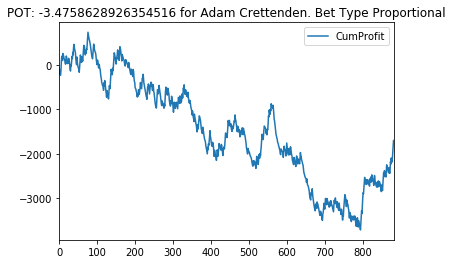

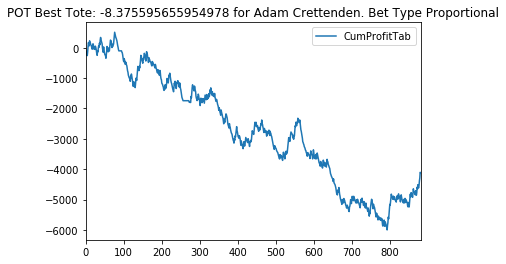

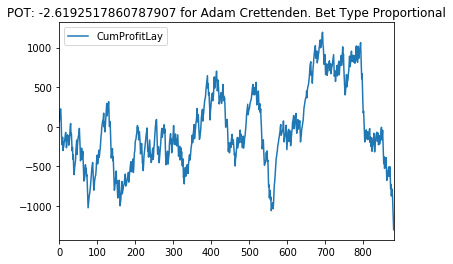

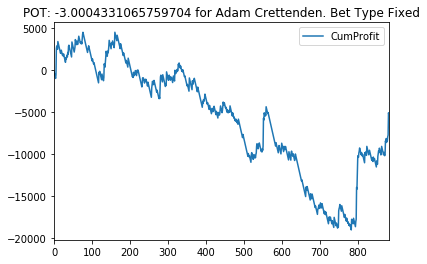

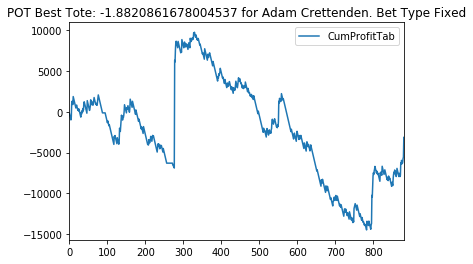

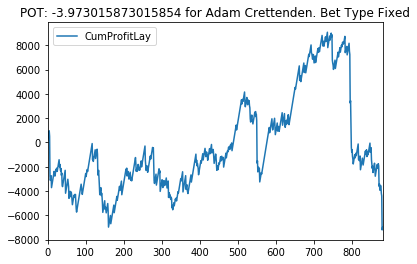

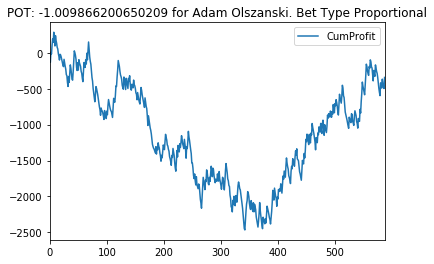

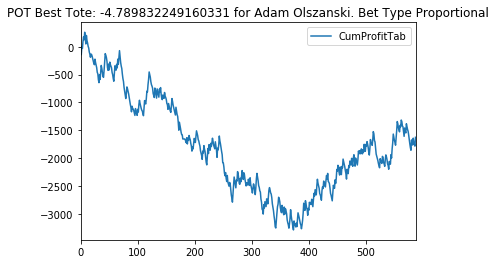

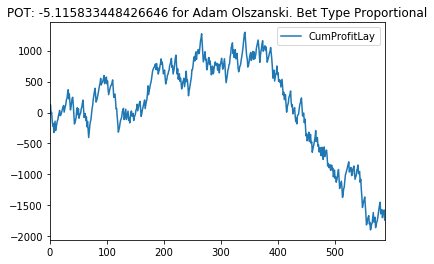

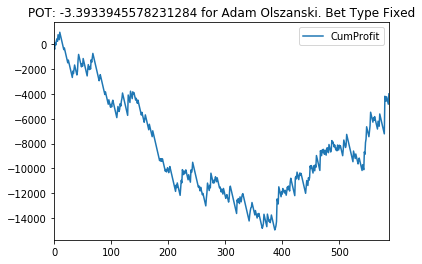

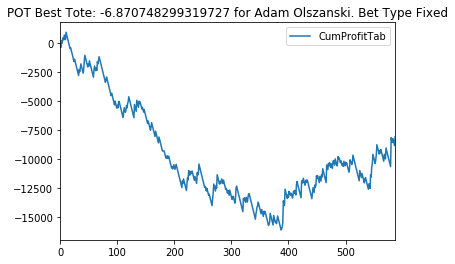

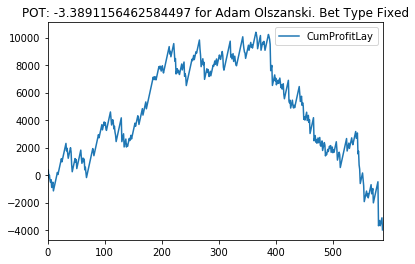

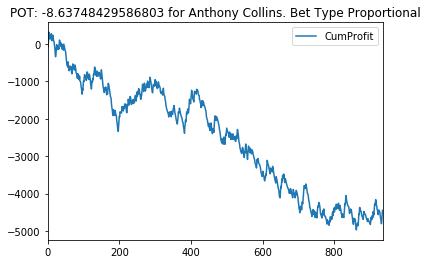

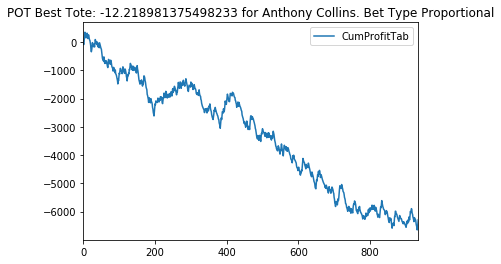

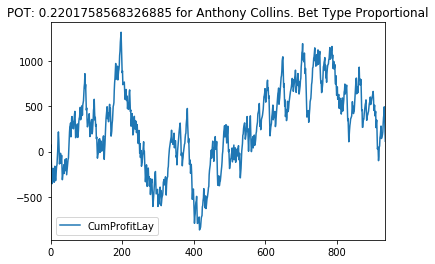

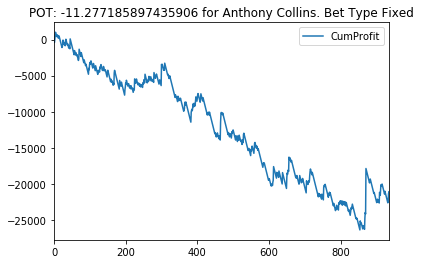

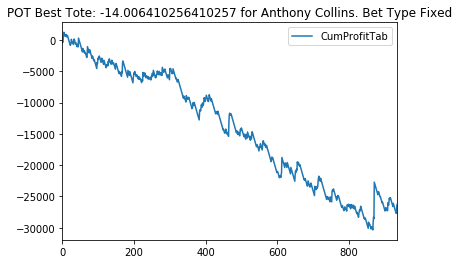

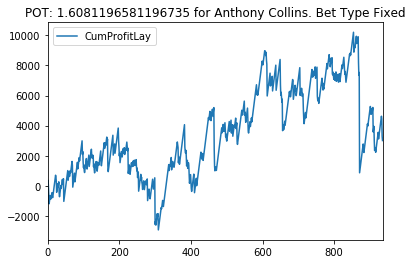

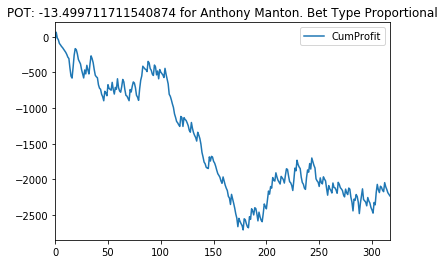

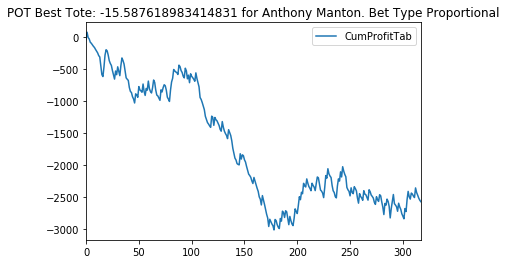

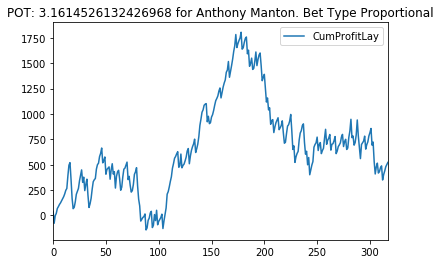

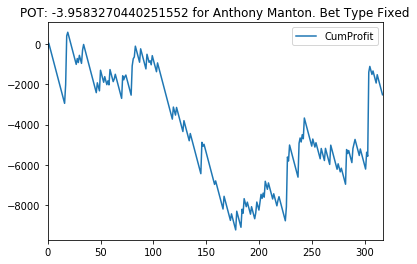

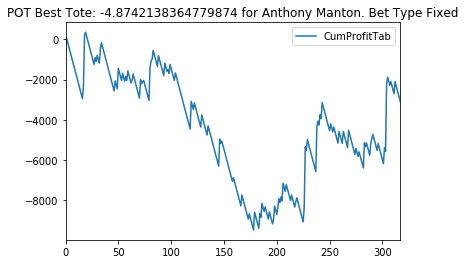

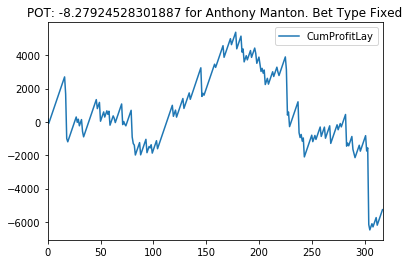

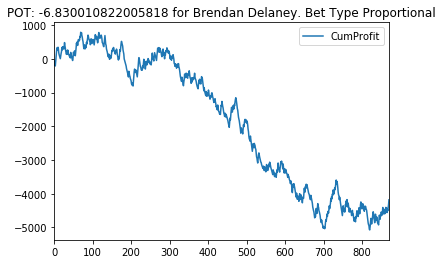

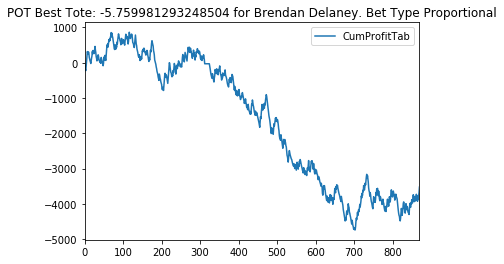

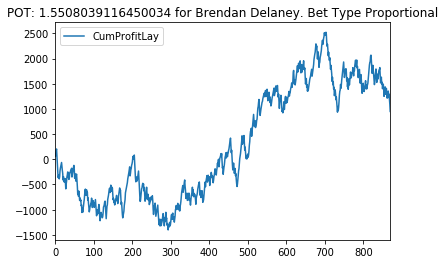

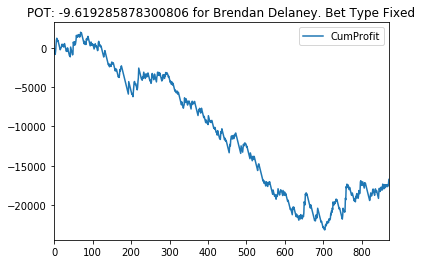

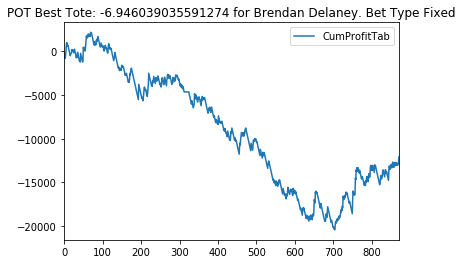

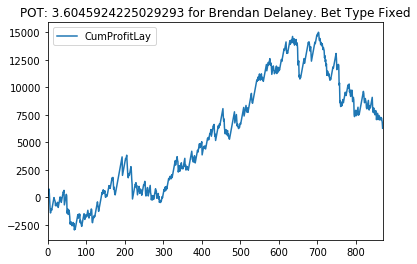

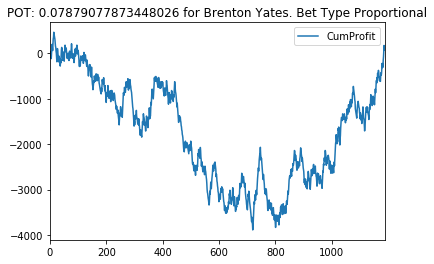

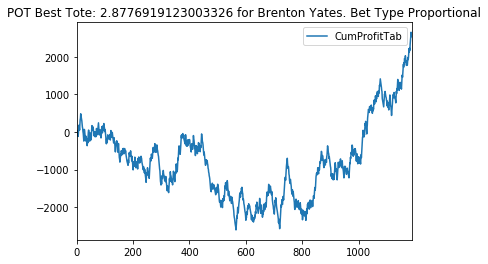

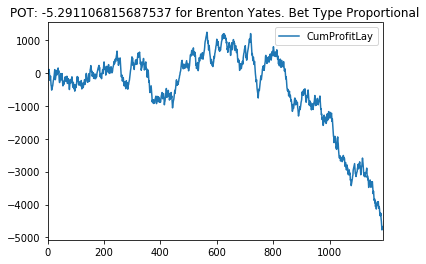

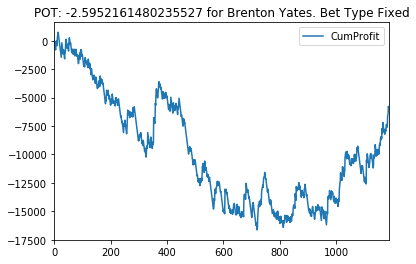

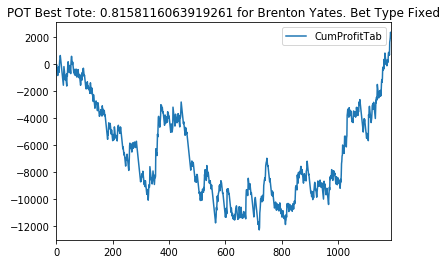

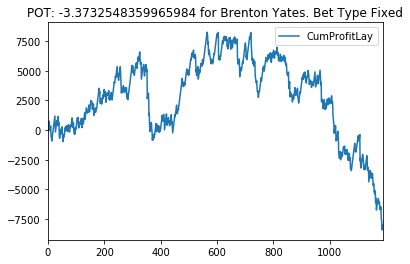

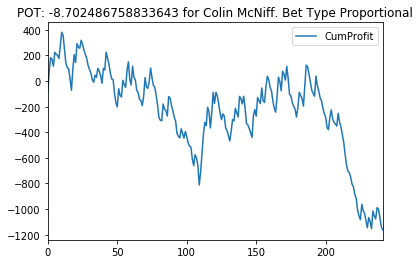

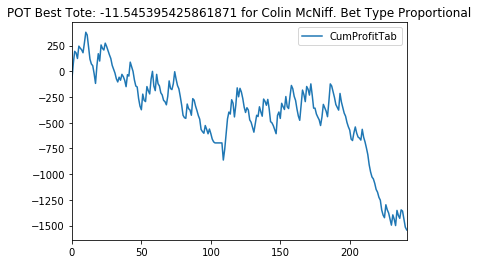

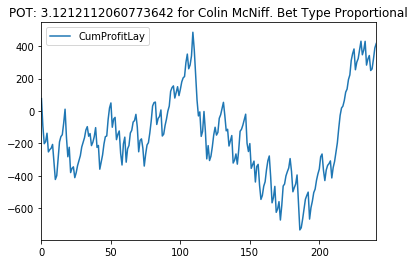

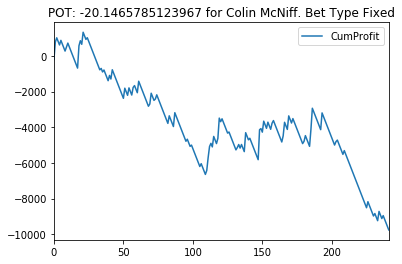

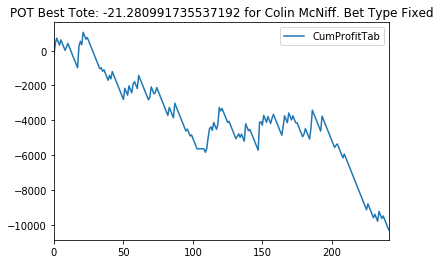

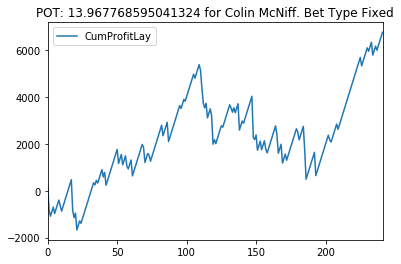

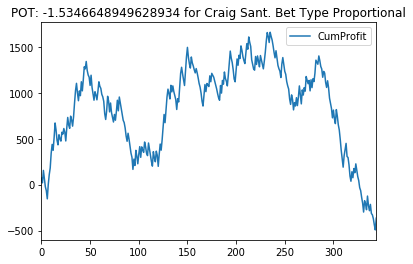

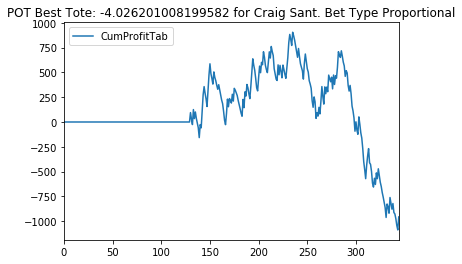

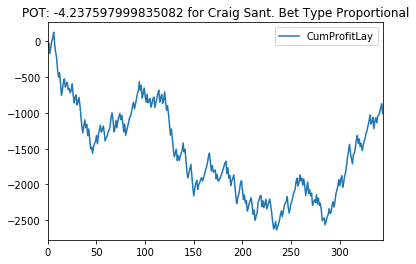

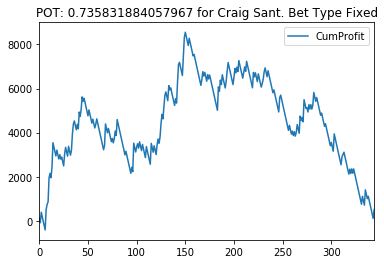

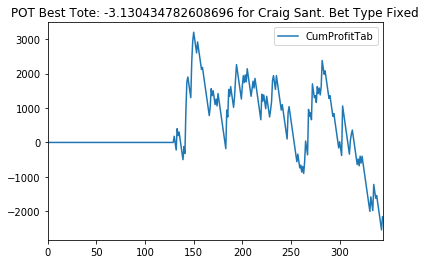

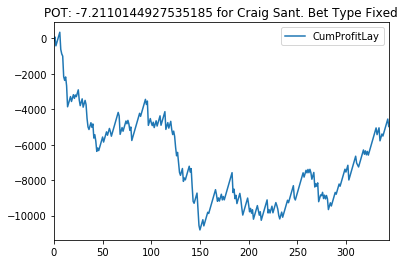

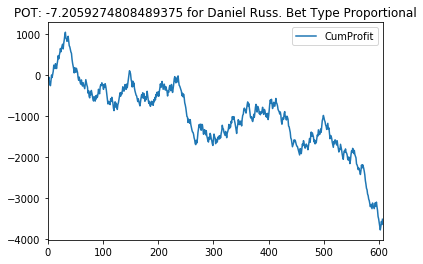

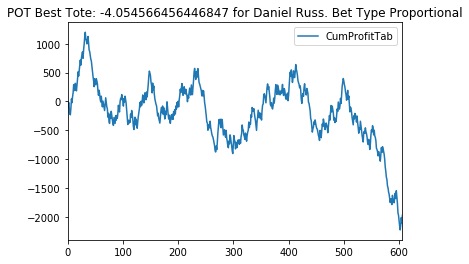

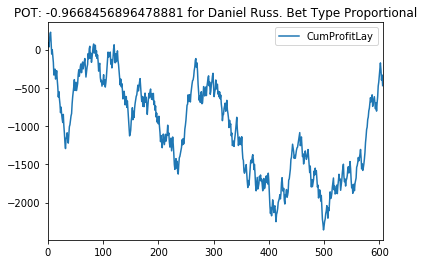

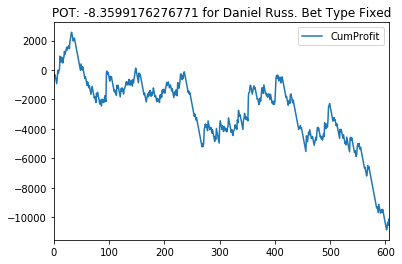

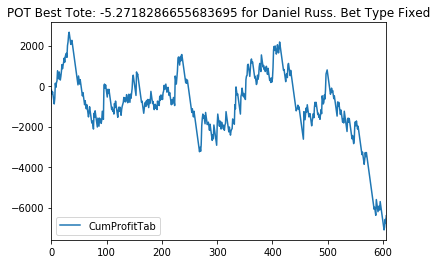

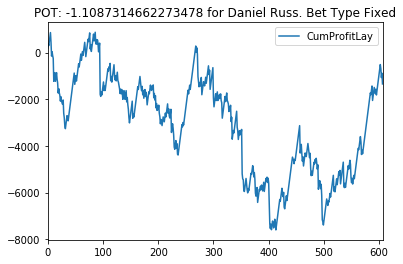

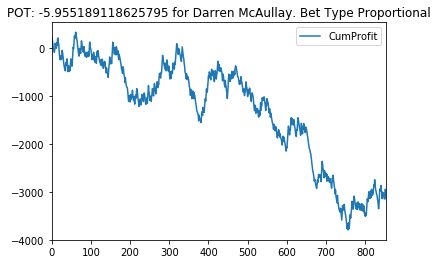

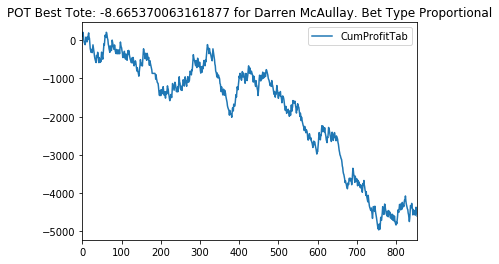

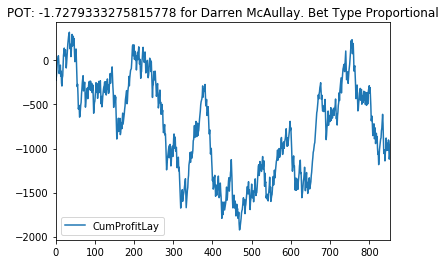

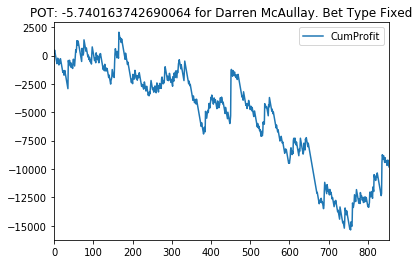

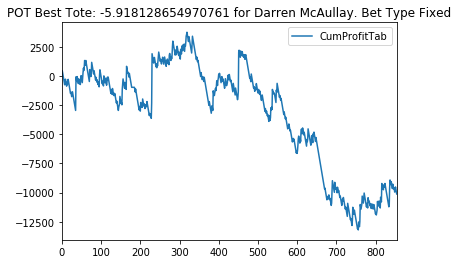

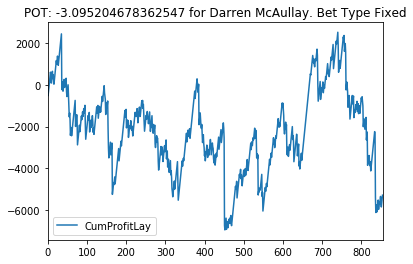

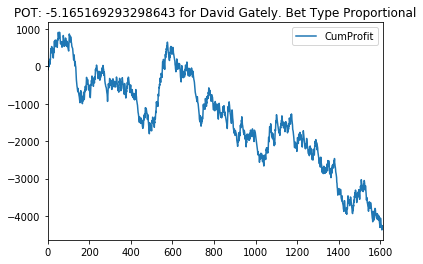

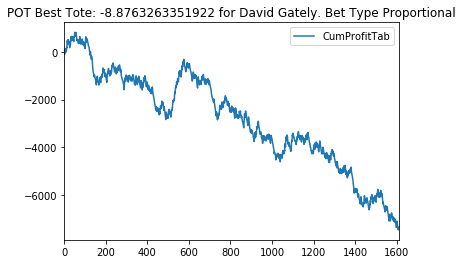

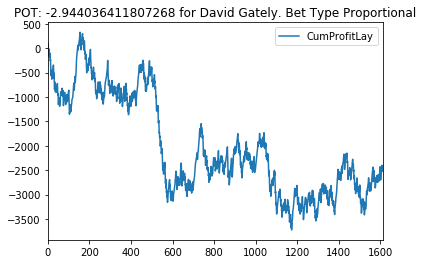

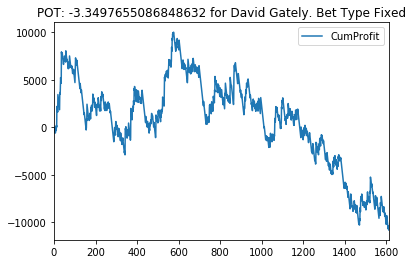

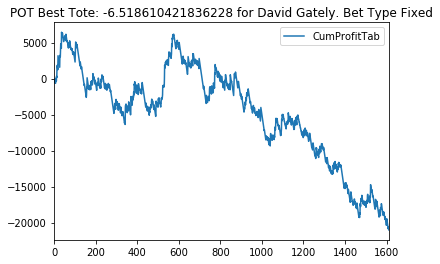

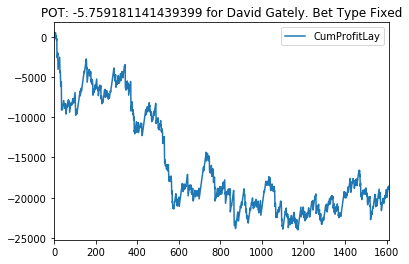

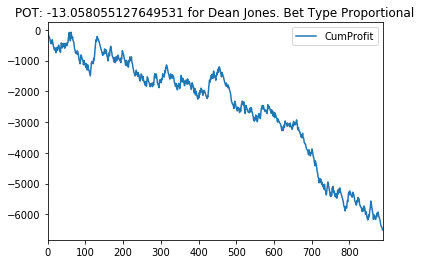

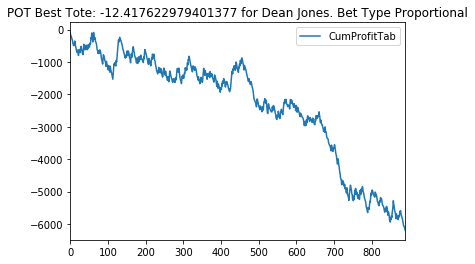

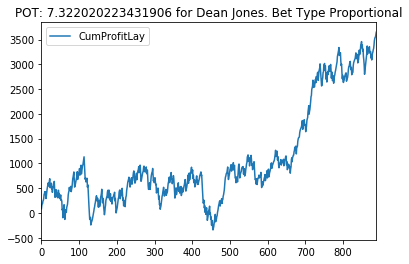

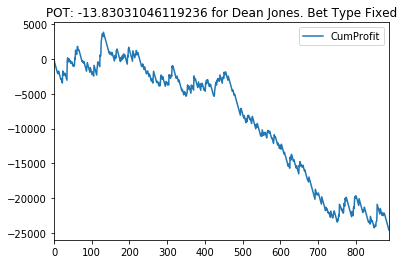

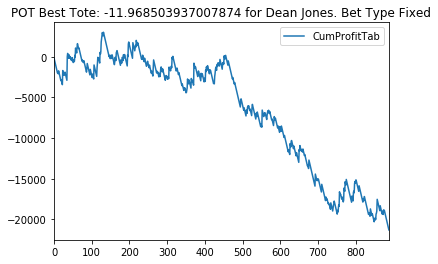

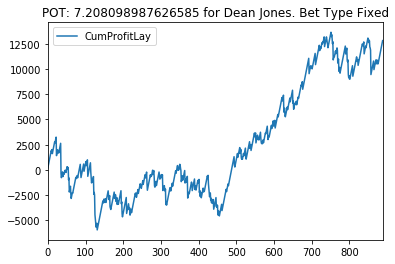

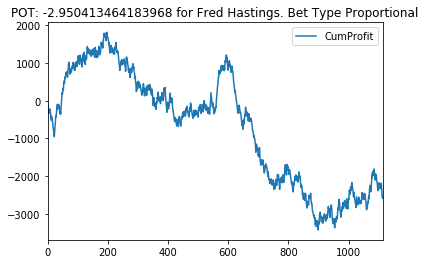

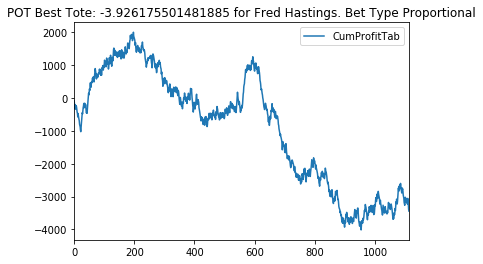

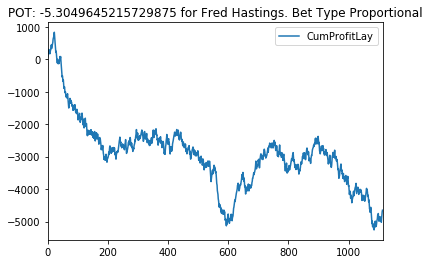

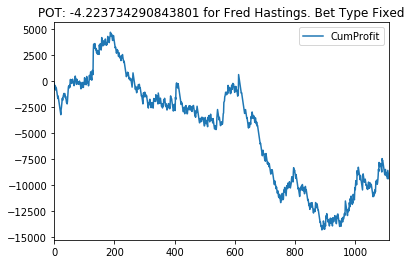

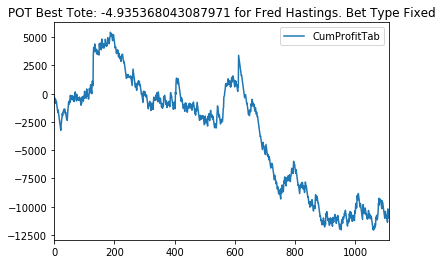

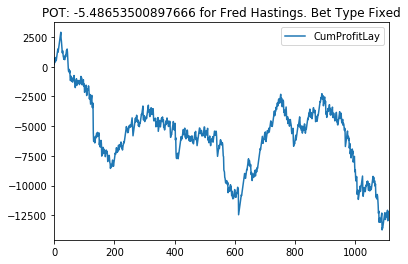

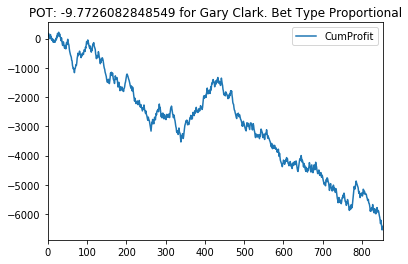

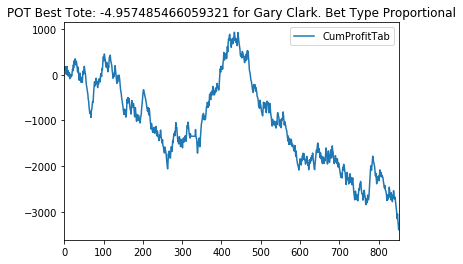

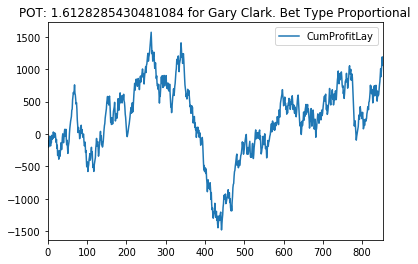

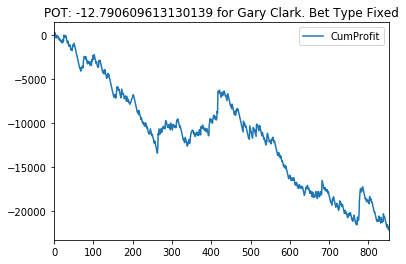

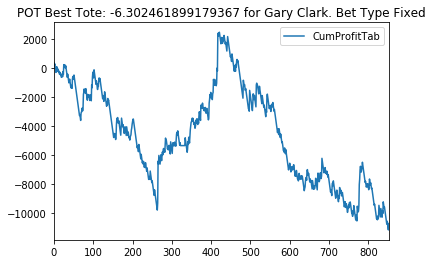

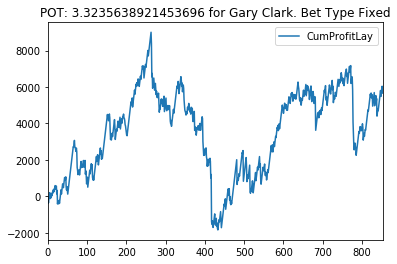

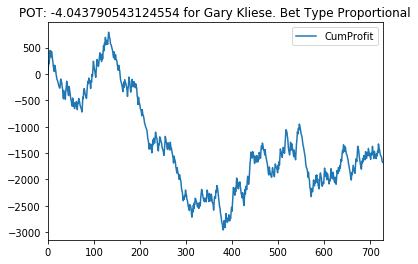

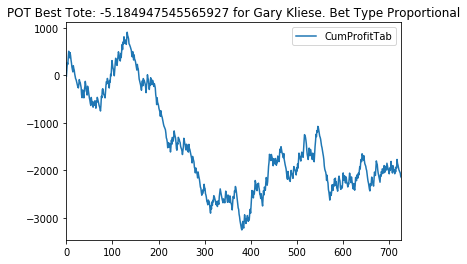

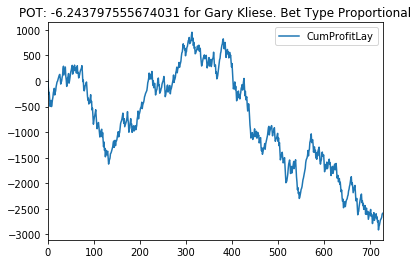

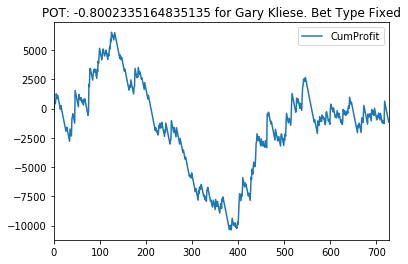

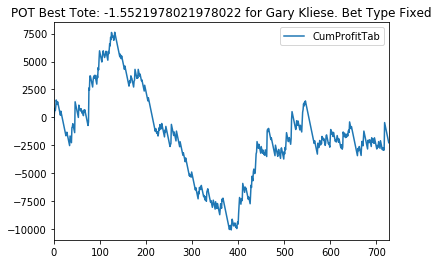

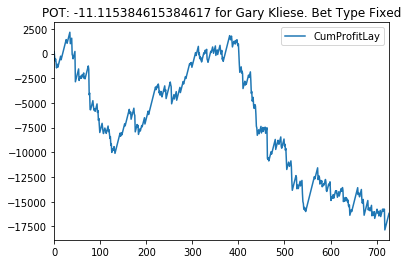

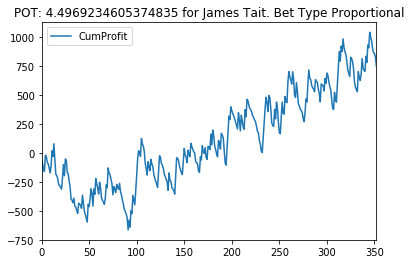

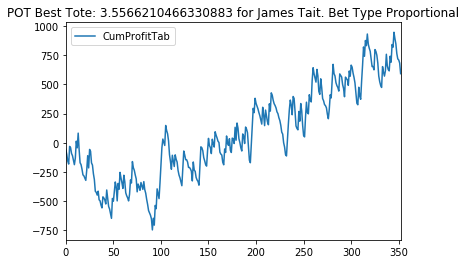

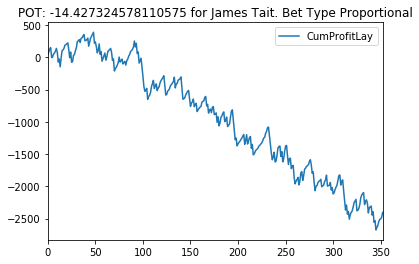

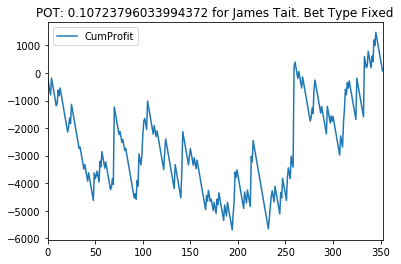

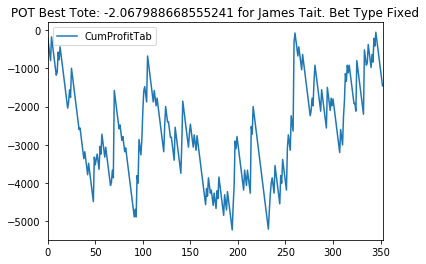

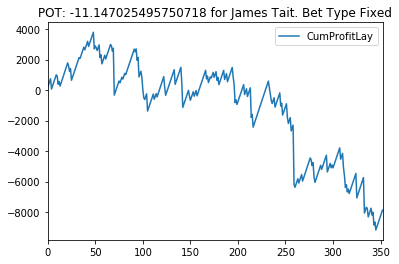

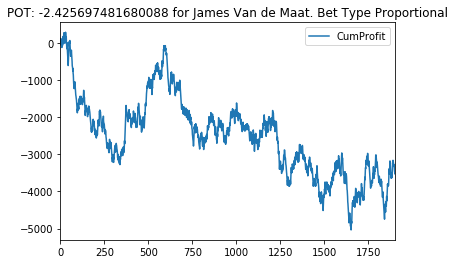

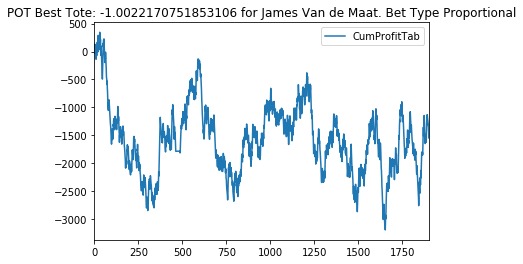

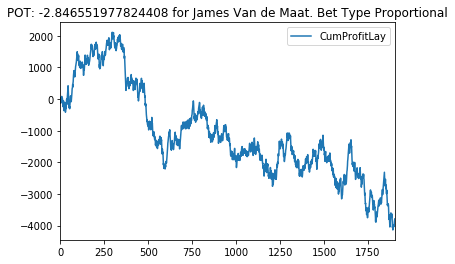

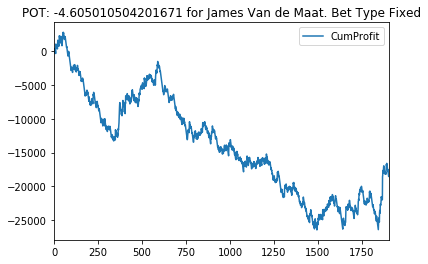

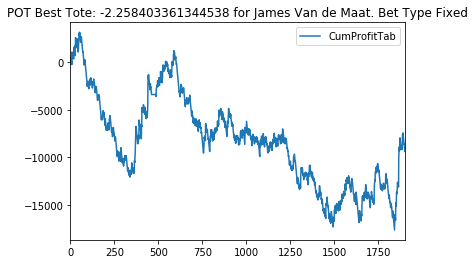

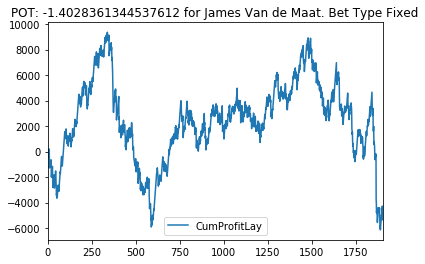

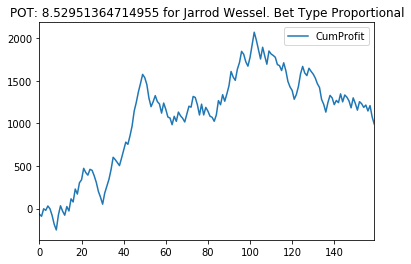

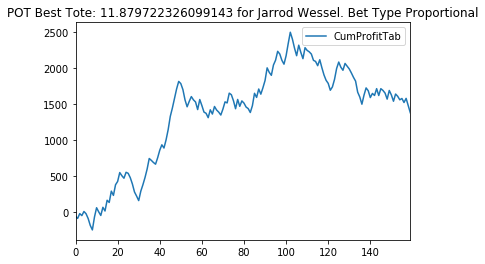

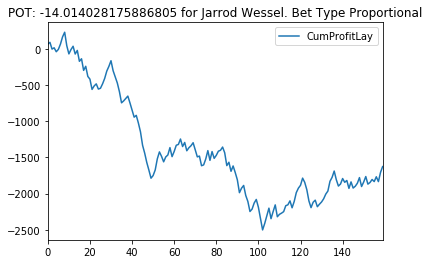

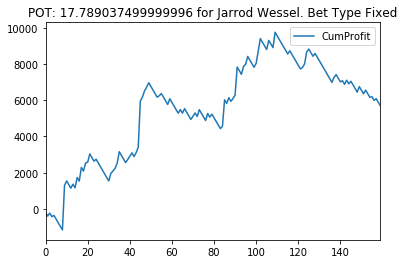

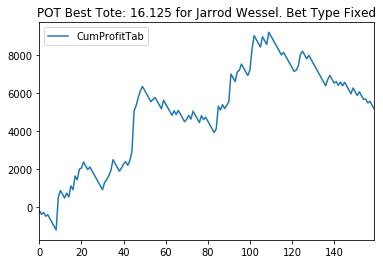

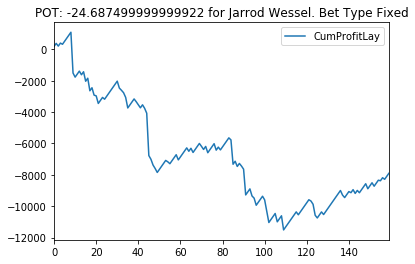

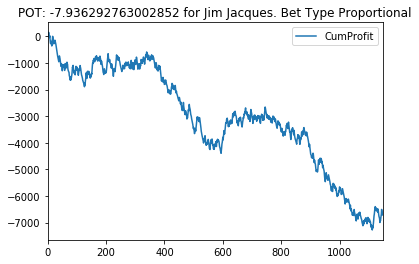

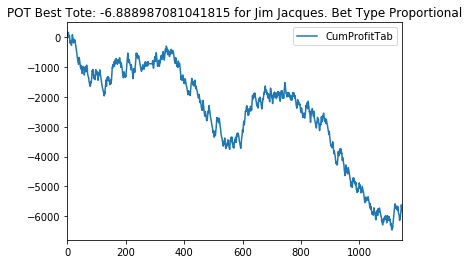

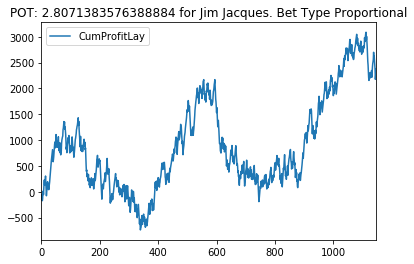

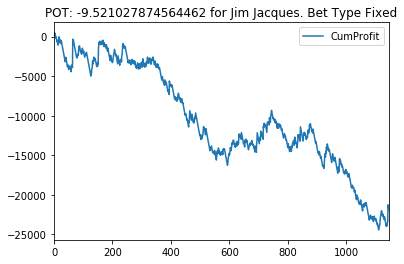

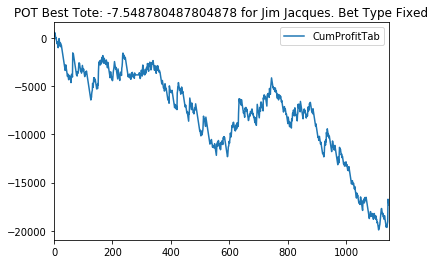

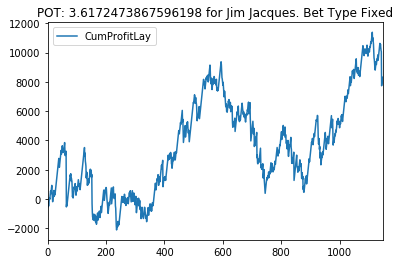

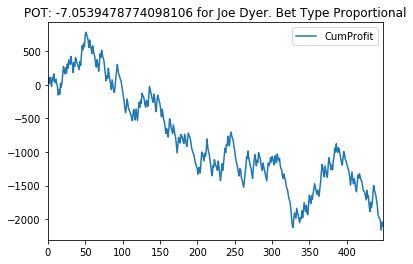

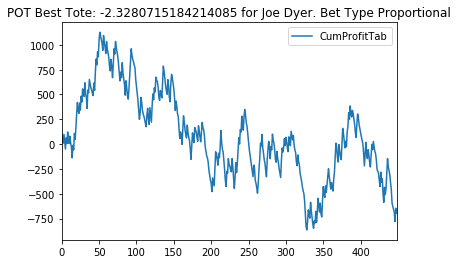

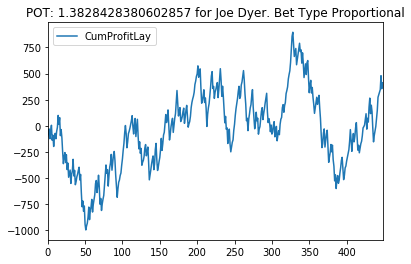

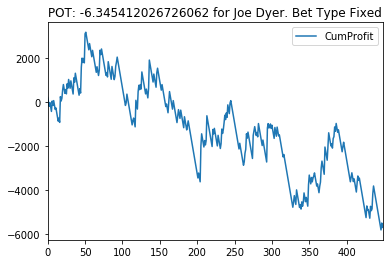

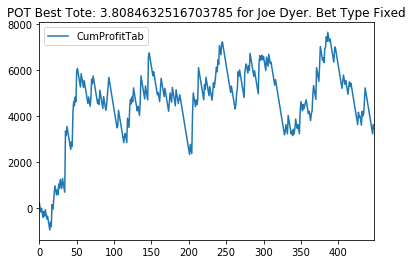

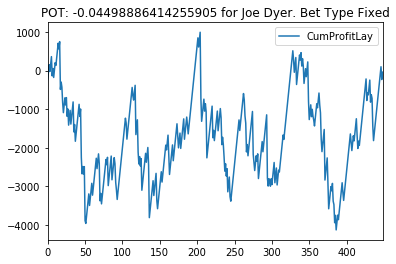

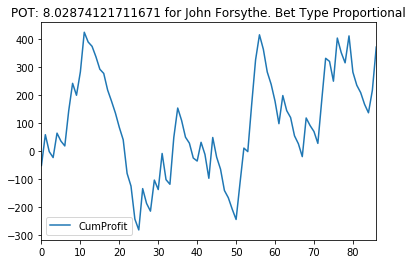

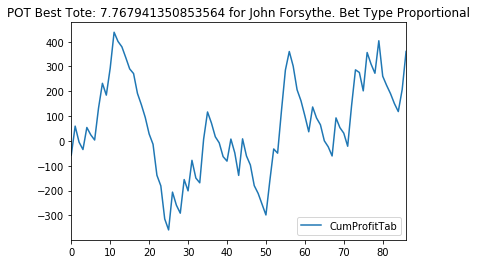

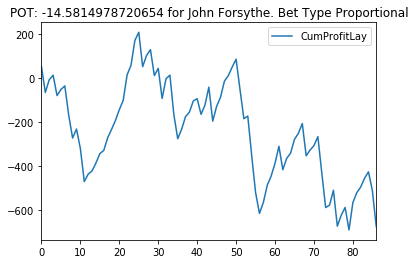

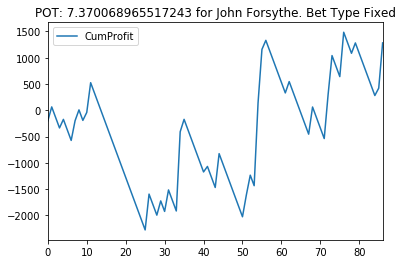

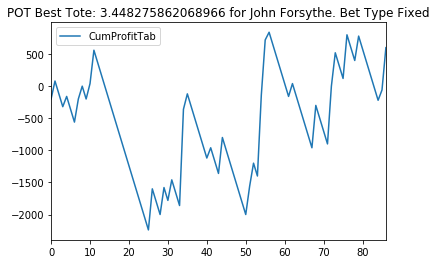

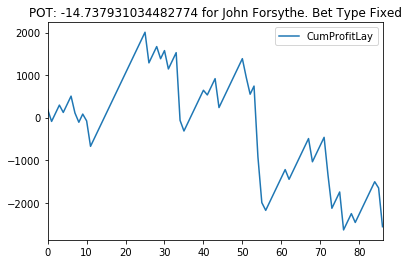

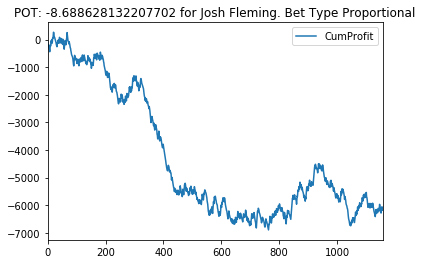

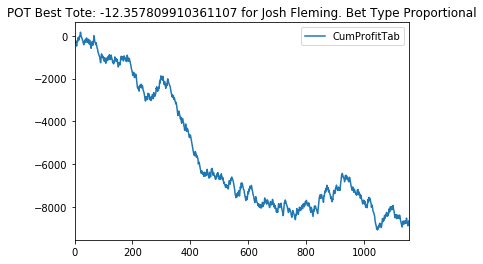

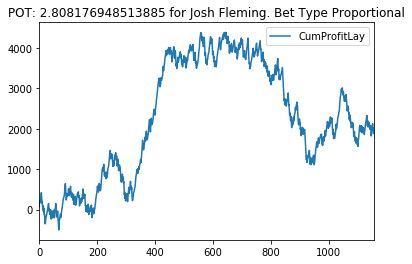

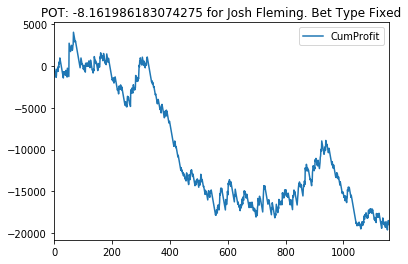

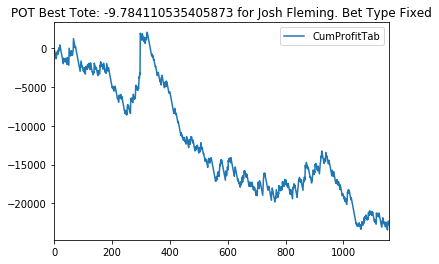

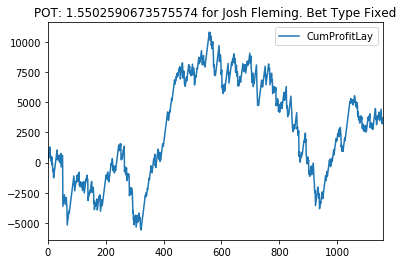

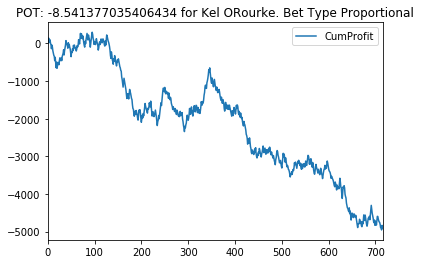

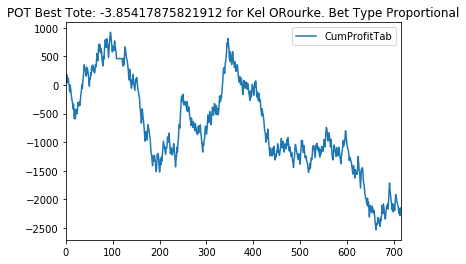

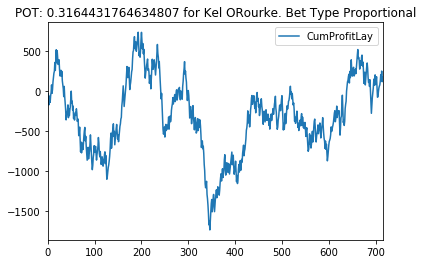

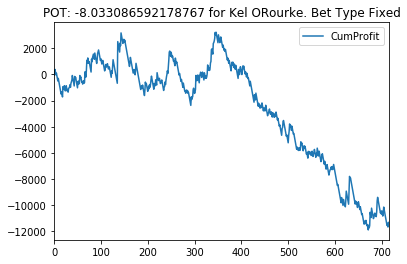

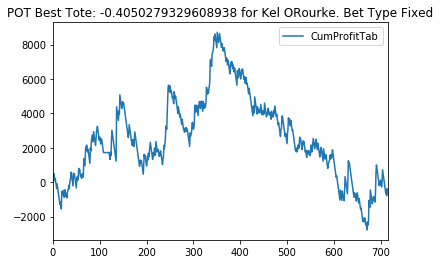

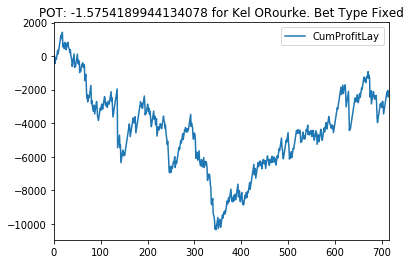

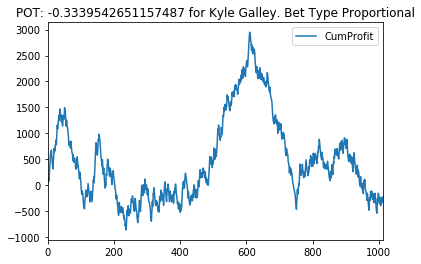

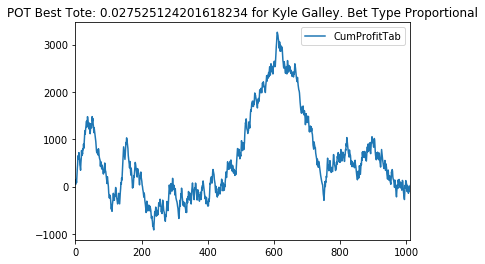

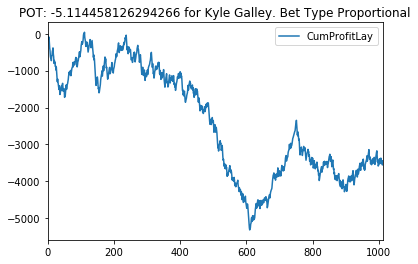

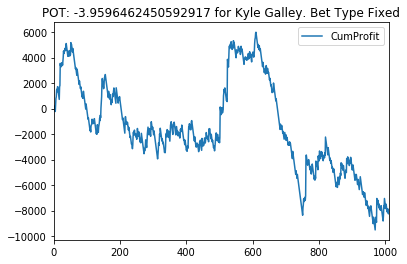

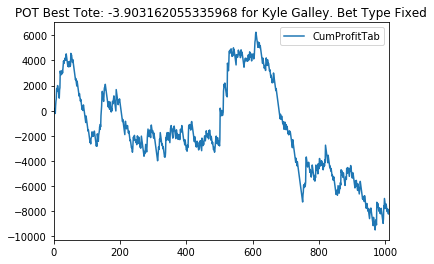

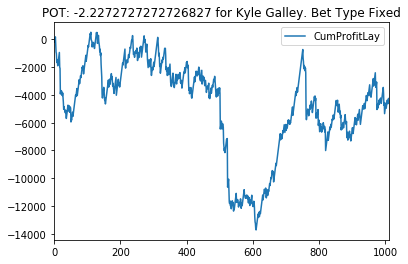

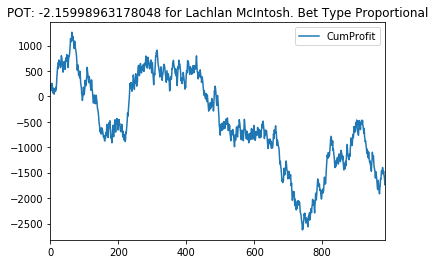

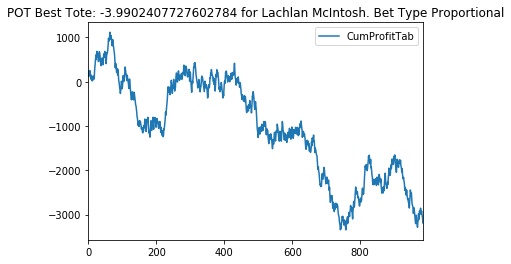

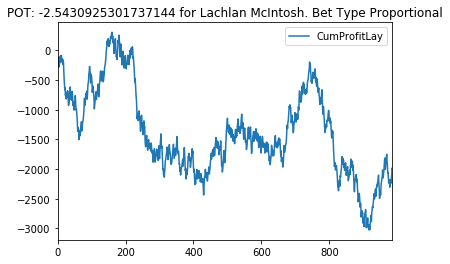

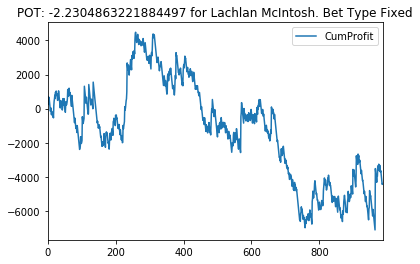

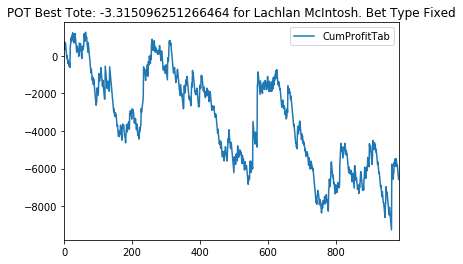

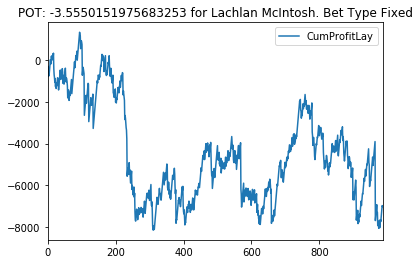

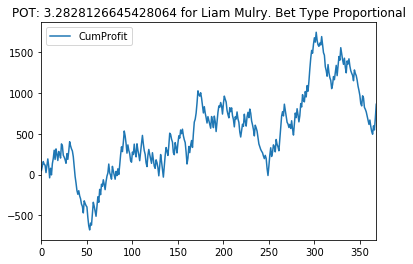

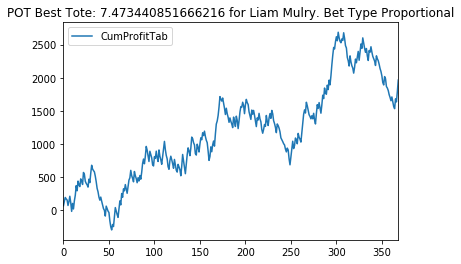

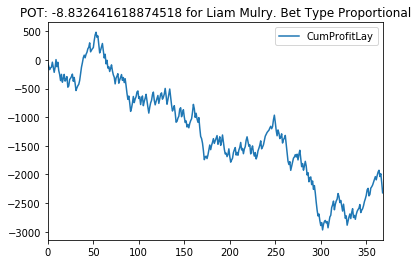

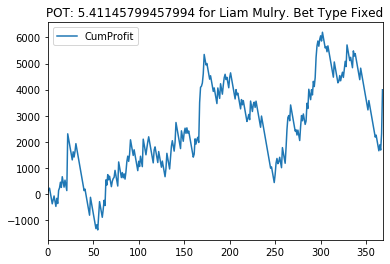

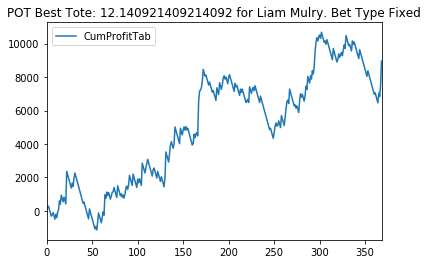

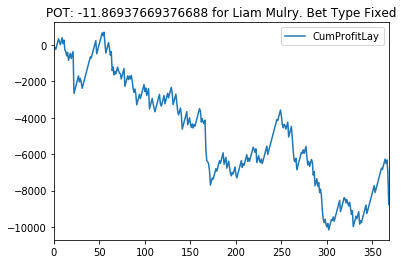

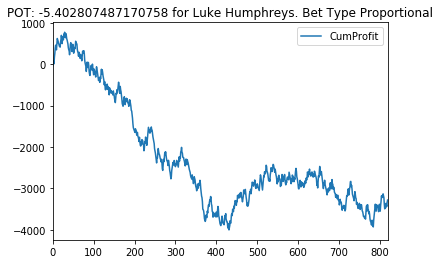

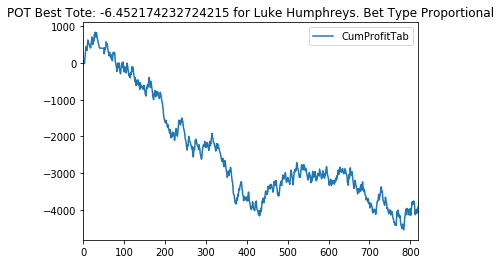

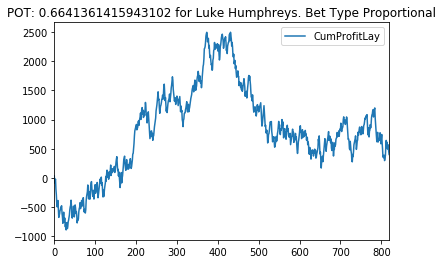

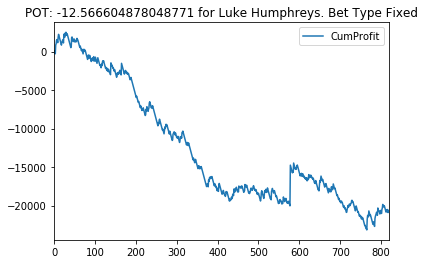

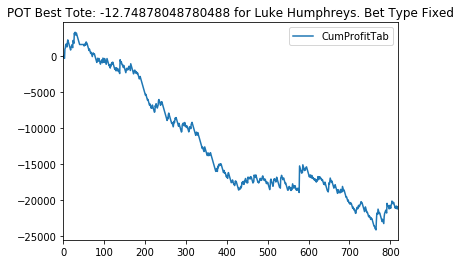

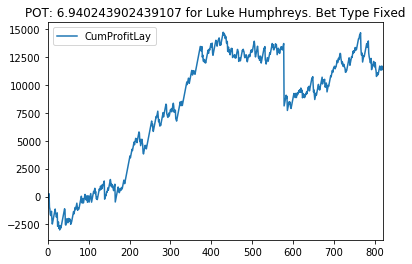

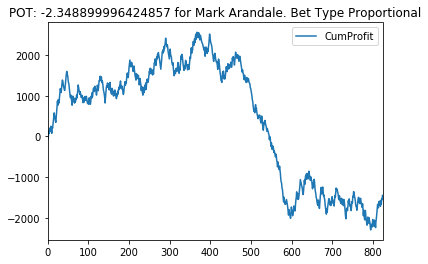

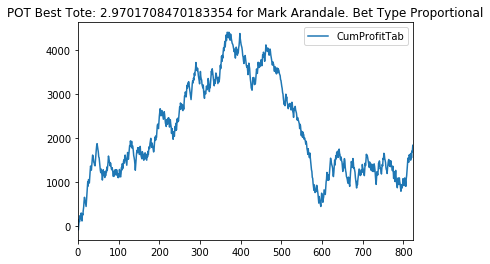

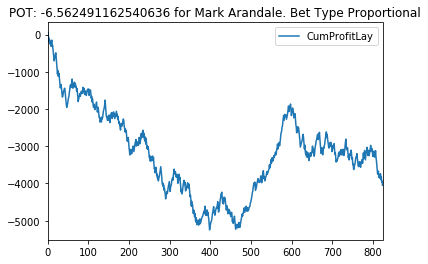

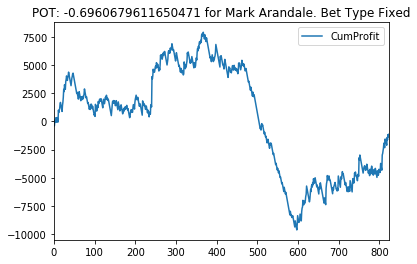

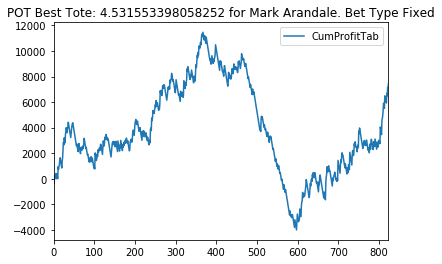

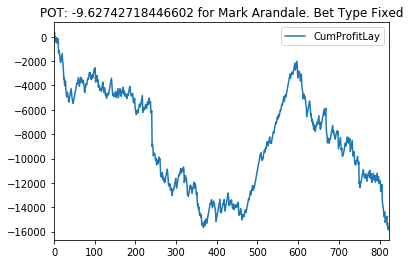

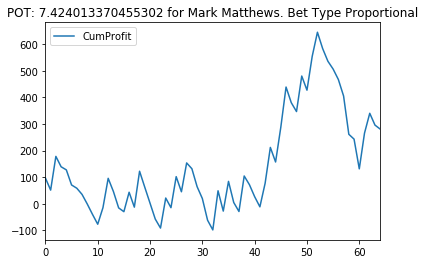

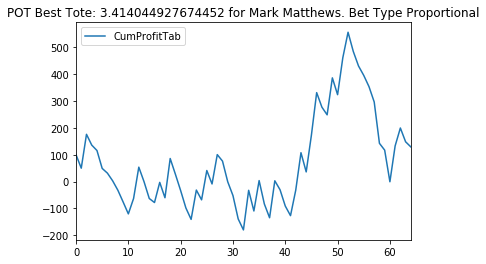

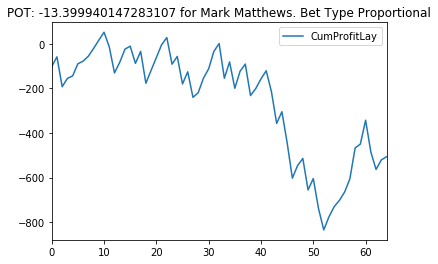

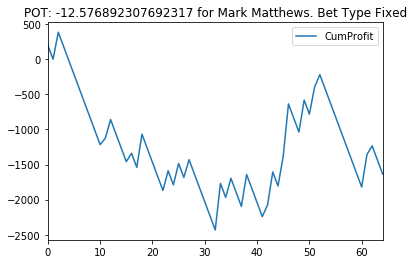

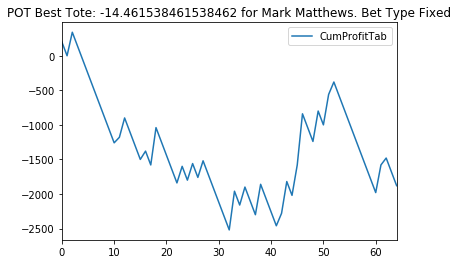

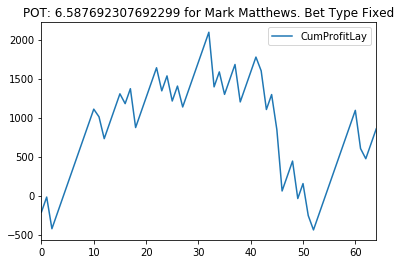

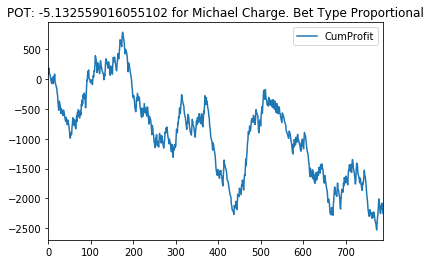

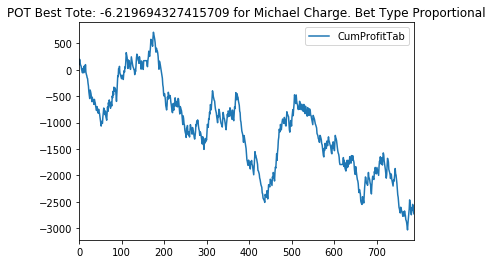

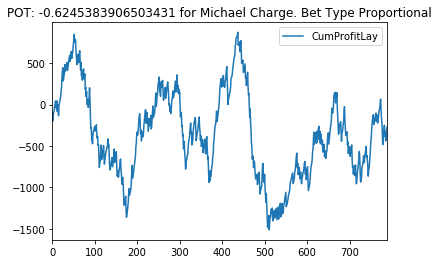

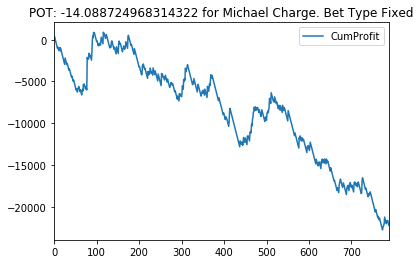

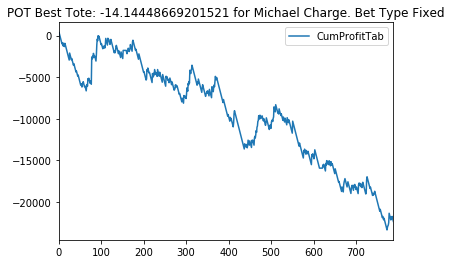

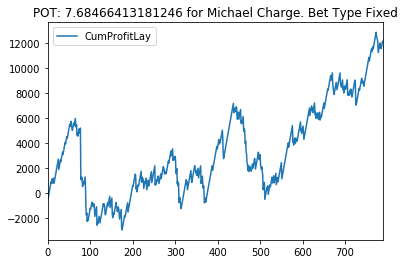

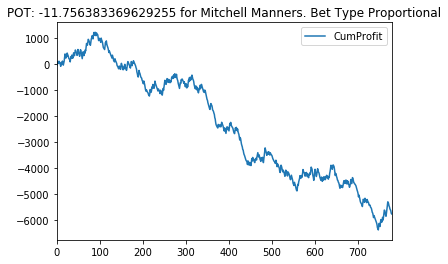

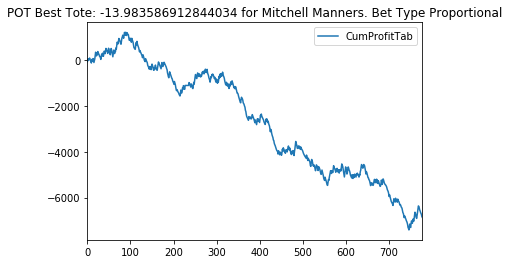

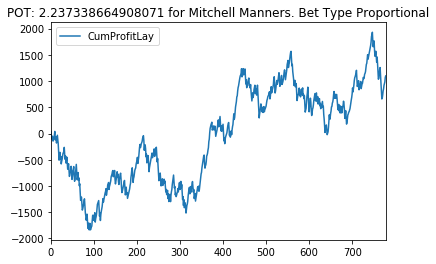

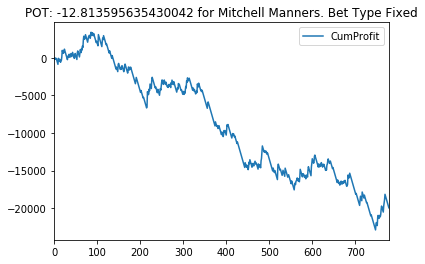

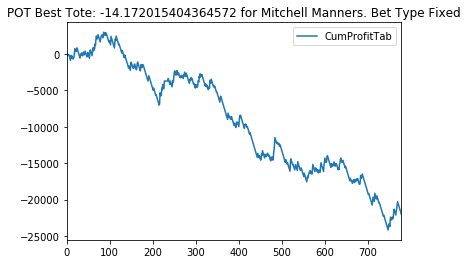

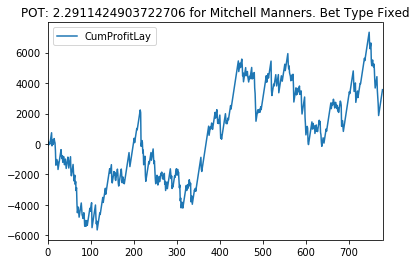

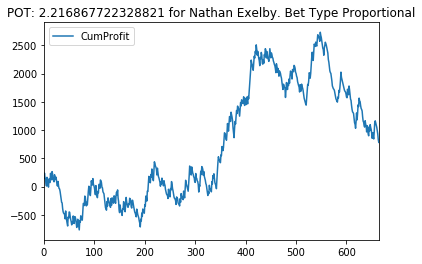

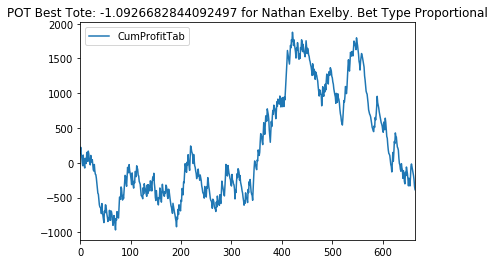

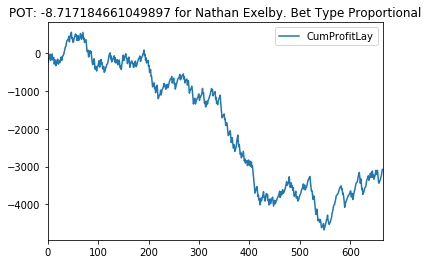

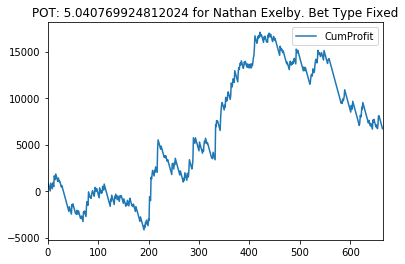

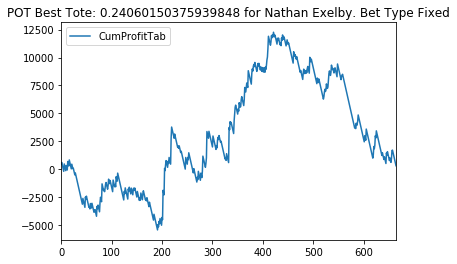

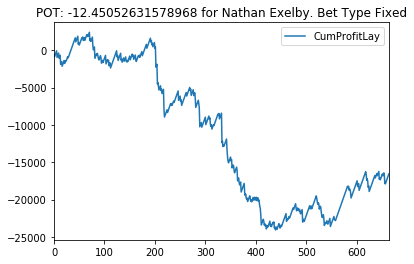

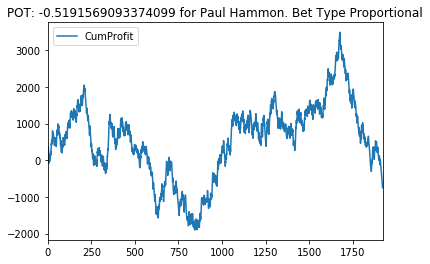

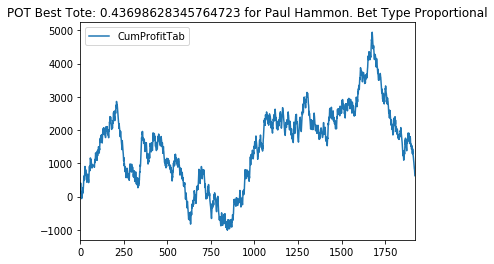

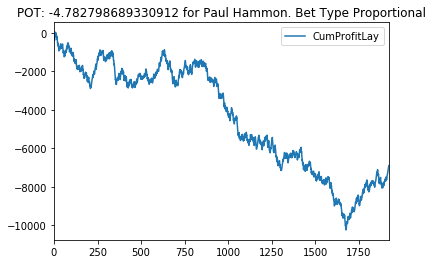

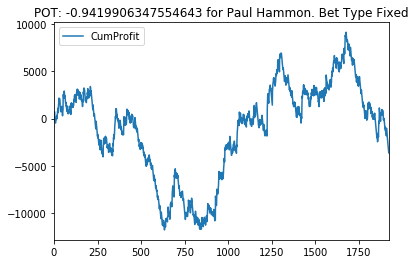

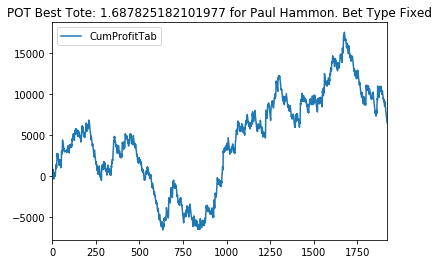

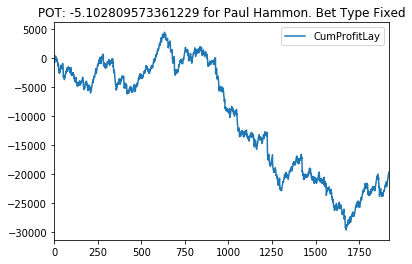

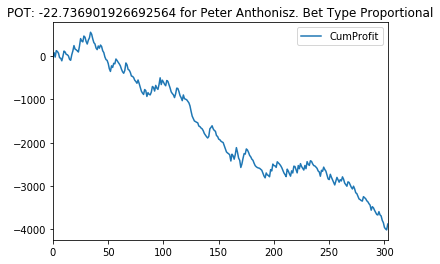

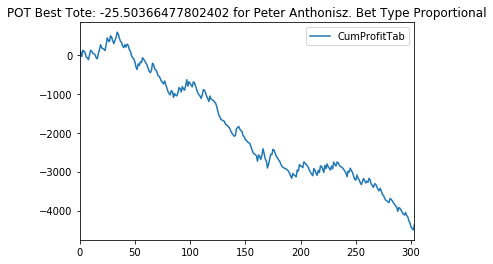

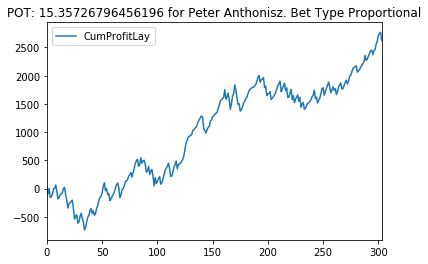

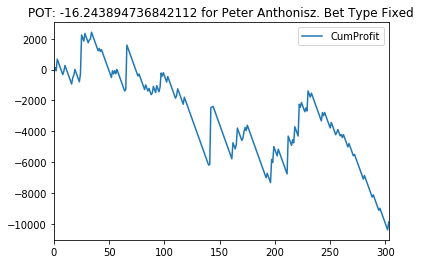

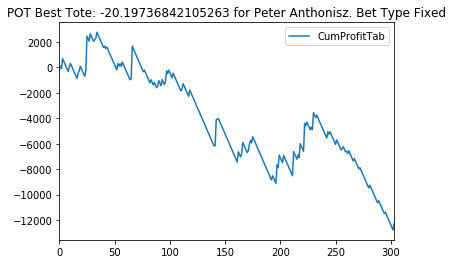

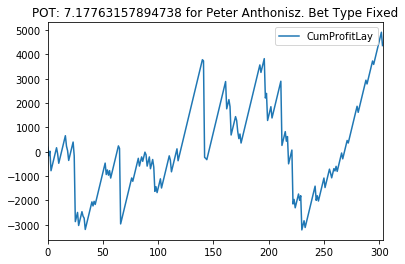

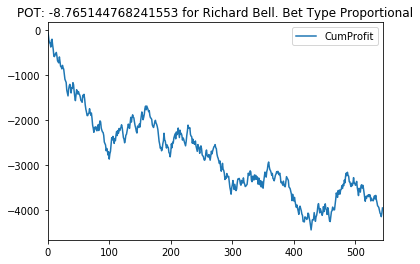

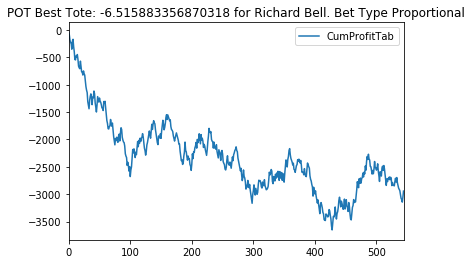

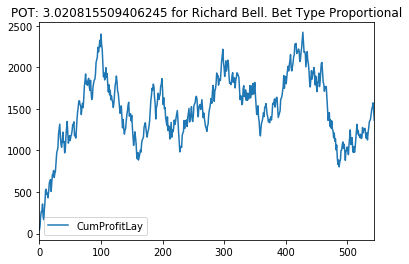

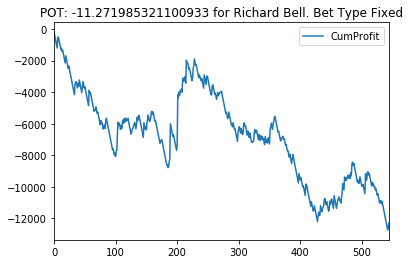

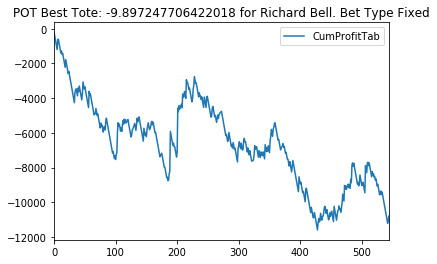

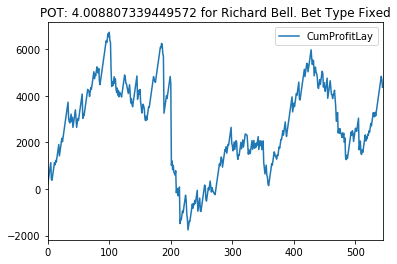

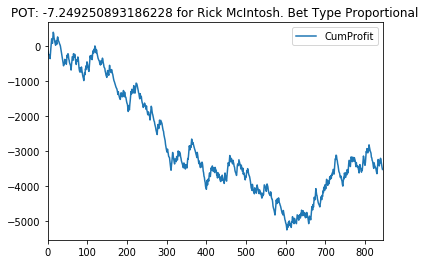

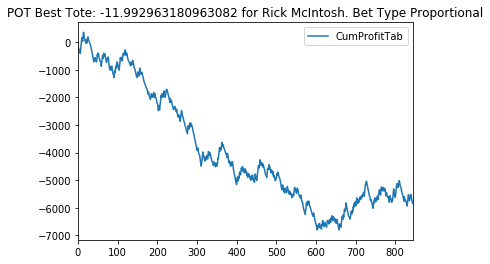

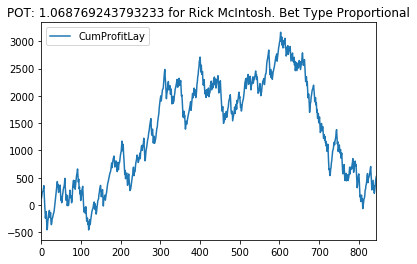

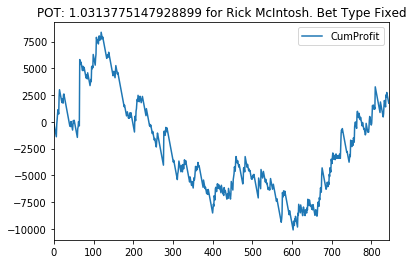

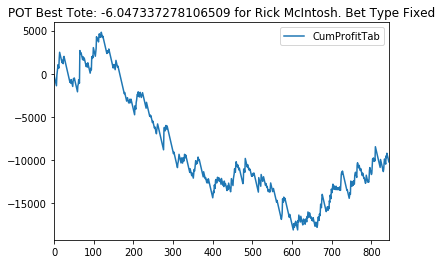

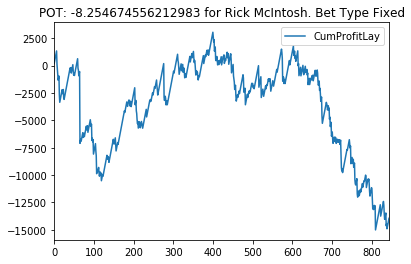

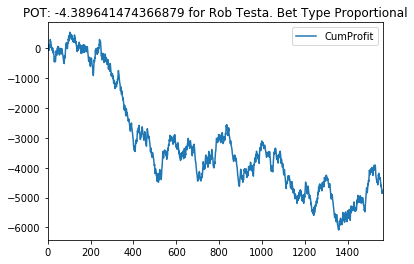

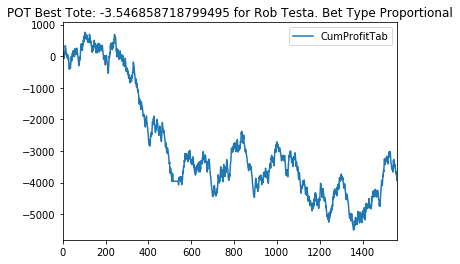

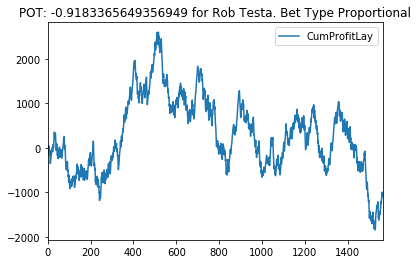

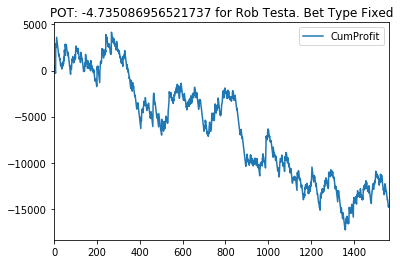

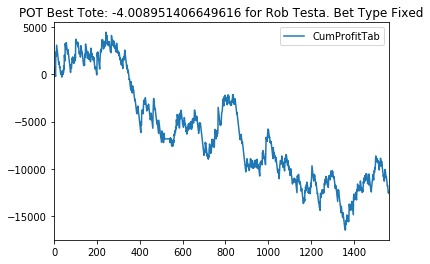

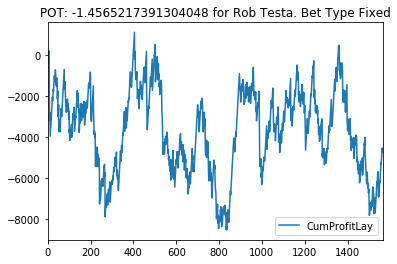

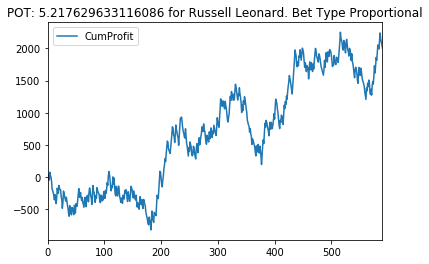

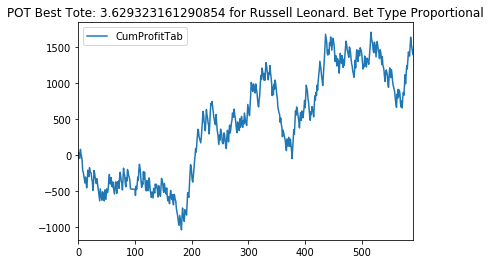

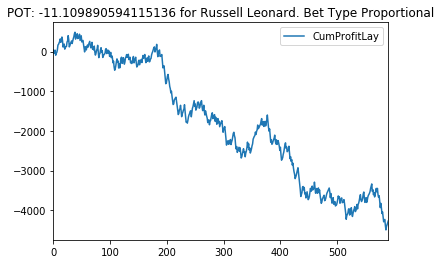

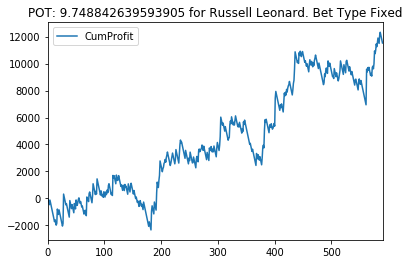

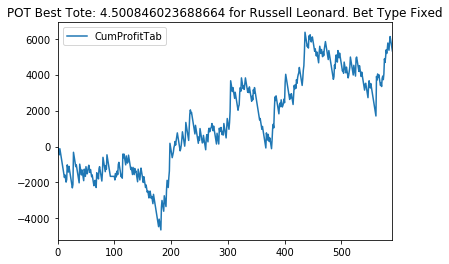

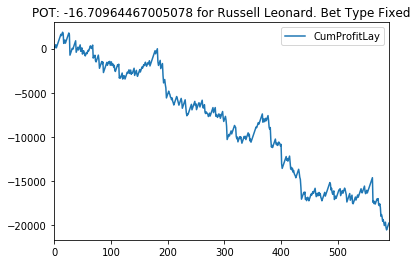

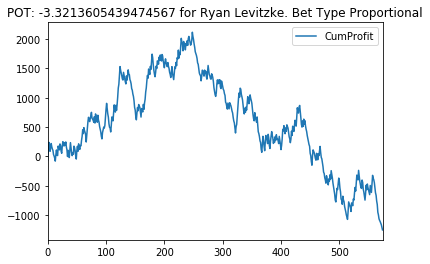

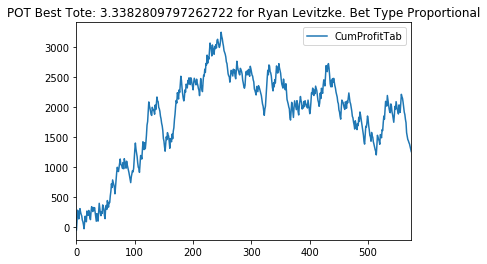

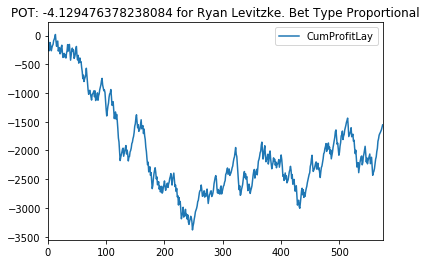

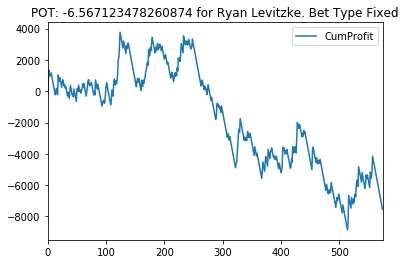

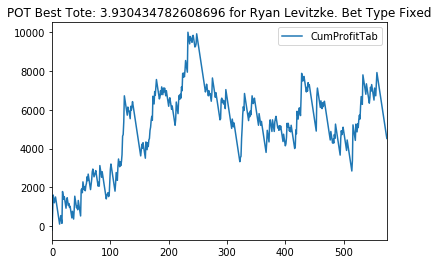

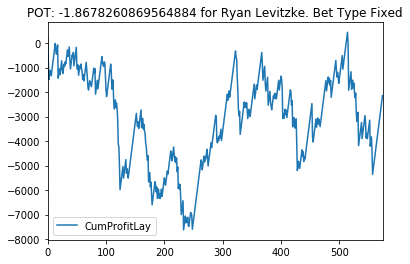

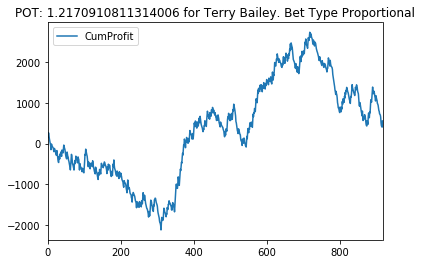

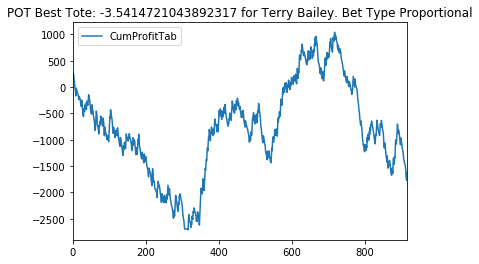

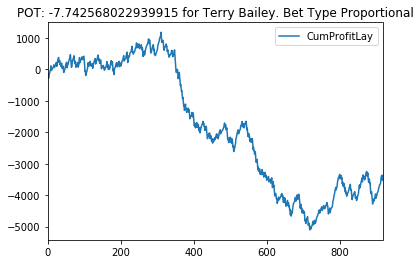

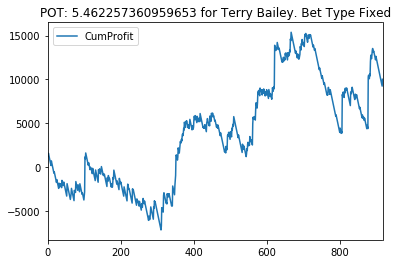

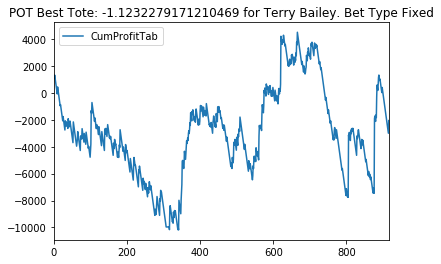

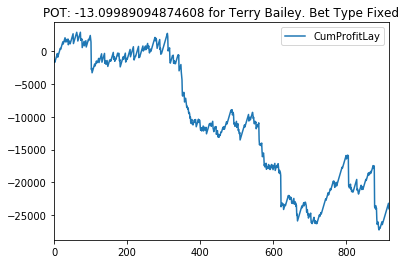

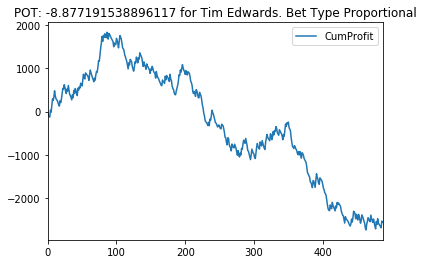

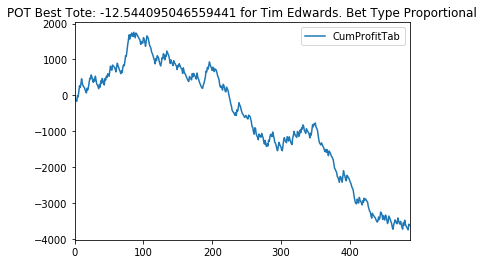

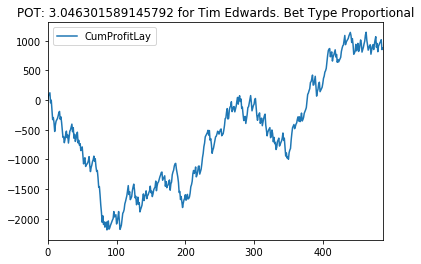

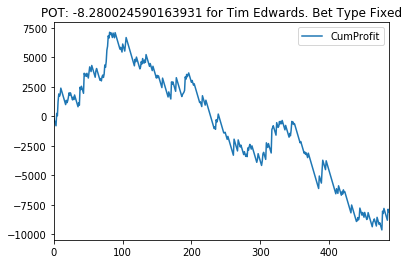

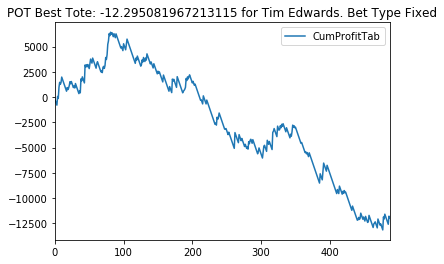

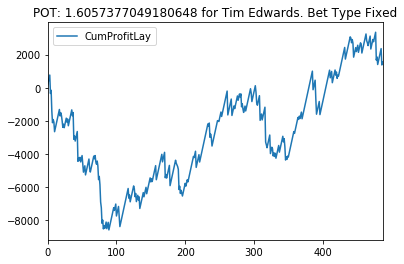

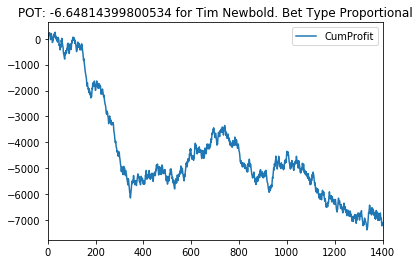

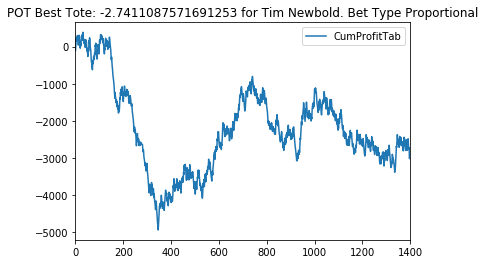

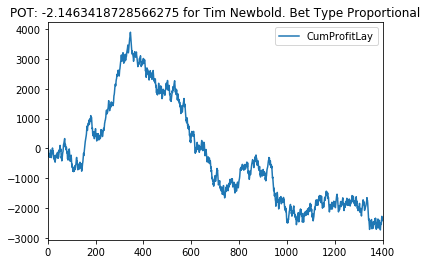

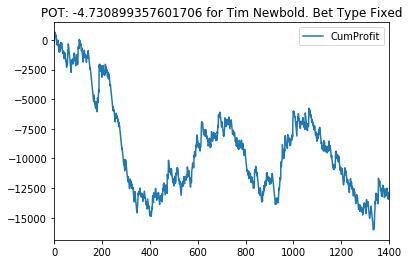

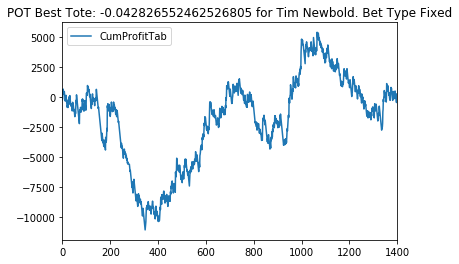

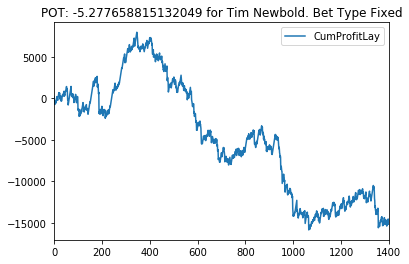

In [11]:
results = {}
for tipster in tipsters:
    tipsFromTipster = tipsWithBetfair[tipsWithBetfair['Tipster'] == tipster].copy()
    tipsFromTipster.sort_values(by=['MeetingDate', 'RaceNumber'], inplace=True)
    tipsFromTipster.reset_index(drop=True, inplace=True)
    
    betTypes = ['Proportional', 'Fixed']
    
    for betType in betTypes:

        if betType == 'Proportional':
            tipsFromTipster['betSize'] = 200 / tipsFromTipster['BspWin']
            tipsFromTipster['betSizeTab'] = 200 / tipsFromTipster['BestTote']
        else:
            tipsFromTipster['betSize'] = 200
            tipsFromTipster['betSizeTab'] = 200
            
        tipsFromTipster['Profit'] = tipsFromTipster[['BspWin', 'MBR', 'WON', 'betSize']].apply(lambda x: BackProfit(*x), axis=1)
        tipsFromTipster['ProfitTab'] = tipsFromTipster[['BestTote', 'MBR', 'WON', 'betSizeTab']].apply(lambda x: BackProfitTab(*x), axis=1)
        tipsFromTipster['ProfitLay'] = tipsFromTipster[['BspWin', 'MBR', 'WON', 'betSize']].apply(lambda x: LayProfit(*x), axis=1)

        tipsFromTipster.dropna(subset = ['Profit', 'ProfitLay'], inplace=True)
        tipsFromTipster.reset_index(drop=True, inplace=True)
        
        tipsFromTipster = tipsFromTipster.drop_duplicates()
        tipsFromTipster.reset_index(drop=True, inplace=True)

        tipsFromTipster['CumProfit'] = tipsFromTipster.Profit.cumsum()
        tipsFromTipster['CumProfitTab'] = tipsFromTipster.ProfitTab.cumsum()
        tipsFromTipster['CumProfitLay'] = tipsFromTipster.ProfitLay.cumsum()
        pot = tipsFromTipster['CumProfit'].iloc[-1] / tipsFromTipster['betSize'].sum() * 100
        potTab = tipsFromTipster['CumProfitTab'].iloc[-1] / tipsFromTipster['betSize'].sum() * 100
        potLay = tipsFromTipster['CumProfitLay'].iloc[-1] / tipsFromTipster['betSize'].sum() * 100

        results[tipster + ' - ' + betType] = tipsFromTipster

        summary = "POT: {} for {}. Bet Type {}". format(pot, tipster, betType)
        summaryTab = "POT Best Tote: {} for {}. Bet Type {}". format(potTab, tipster, betType)
        summaryLay = "POT: {} for {}. Bet Type {}". format(potLay, tipster, betType)
        tipsFromTipster.plot(y='CumProfit', title=summary)
        tipsFromTipster.plot(y='CumProfitTab', title=summaryTab)
        tipsFromTipster.plot(y='CumProfitLay', title=summaryLay)

In [12]:
tipster = 'David Gately - Proportional'
results[tipster].to_csv(tipster + '.csv', index=False, date_format='%Y%m%d')